In [ ]:
!nvidia-smi

Sat Dec 31 01:48:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# FNC Experts and Semantic Masking

Here, we train the experts for Semantic Masking.

We provide code to perform experiments over 15 datasets: NELA and subsets ('18, '19, '20, '21), Fakeddit, the 11 datasets from EFND.

For each dataset, we perform the following experiments :

1. (nomask) No masking
2. (rtm) Random token masking
3. (rwm) Random word masking
5. (ktm_tfidf / kwm_tfidf) Token/Word masking, with tokens/words obtained from tfidf
6. (ktm_att / kwm_att) Token/Word masking, with tokens/words obtained from attention
7. (ktrtm_tfidf / kwrwm_tfidf) Same as 5, but with random masking as well
8. (ktrtm_att / kwrwm_att) Same as 6, but with random masking as well


## General Instructions.

1. You need the directory at this [Shared Google Drive link](https://drive.google.com/drive/folders/1T5JY6Mm9lmLQ-fT3O2nldG-d99XumUSj?usp=share_link). The directory at this link should be imported as `Datasets` into your Google Drive so that they can be copied into the runtime during execution.
2. You need to create a Projects directory at the top level of your Google Drive, if you will be backing up any models.
3. In this notebook, steps 0-6 are relevant for Semantic Masking.
4. Step 0 connects to your google drive, clones the git repository containing the framework we will use, and creates the `Data` directory in this runtime.
5. Step 1 performs downloads from the Data directory. It is recommended to run ONLY the downloads you need from inside Step 1. Running all of Step 1 will take way too long.
6. Step 2 sets up the experiment pipeline with configurable options. More details in Step 2.
7. Step 3 runs an experiment per options in Step 2 (e.g. which dataset to use, whether to apply masking or not, etc)
8. Step 4 is a separator, and not important.
9. Steps 5 and 6 can perform the TFIDF and attention based word detection. More details there


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.8 MB/s eta 0:00:00


In [ ]:
#
#!rm -rf -- fnc-expert-efnd-nomask-v1-albert-base-v2-kagglefn_short
!rm -rf -- train-datashard-artifacts/
!rm -rf -- test-datashard-artifacts/

# 0 Setup -- Gdrive Connect, Git clone, Model  Downloads

## Connect to Google Drive

In [ ]:
!nvidia-smi

Wed Feb  8 04:29:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os.path as osp
import os, glob, shutil

In [ ]:
# Set Gogle Drive Connection
#if not osp.exists("./drive"):
from google.colab import drive

#https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%c2%b4t-be-mounted-anymore-browser-popup-google-dri
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Git Clone

### From Source

In [ ]:
! rm -rf -- EdnaML

In [ ]:
! git clone -b devel https://github.com/asuprem/EdnaML

Cloning into 'EdnaML'...
remote: Enumerating objects: 9540, done.
remote: Counting objects: 100% (1443/1443), done.
remote: Compressing objects: 100% (469/469), done.
remote: Total 9540 (delta 892), reused 1373 (delta 827), pack-reused 8097
Receiving objects: 100% (9540/9540), 2.53 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (6283/6283), done.


In [ ]:
!pip install -e EdnaML/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/EdnaML
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
  Running setup.py develop for ednaml


###  From PyPi

In [ ]:
#! python -V

In [ ]:
#! pip3 install --pre ednaml==0.1.4

## AlBERT / ModelFile Data Download

(And assume they are FNC-Extended-MonthYear)

In [ ]:
#!cp ./drive/MyDrive/Datasets/PreTrained/Albertv2/30k* .
#!cp ./drive/MyDrive/Datasets/PreTrained/Albertv2/pytorch_model.bin .
! mkdir Data

# Restart Runtime here!!!

# 1 Data downloads -- You may not need all the data!

## NELA

In [ ]:
import os.path as osp
if not osp.exists("NELA-GT-2020"):
  print("NELA-GT-2020 does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/NELA-GT/NELA-GT-2020/ .
else:
  print("NELA-GT-2020 already exists")

NELA-GT-2020 does not exist. Copying...


In [ ]:
import glob
import os, shutil
sources = glob.glob("NELA-GT-2020/*.zip")
dest = "Data"
os.makedirs(dest, exist_ok=True)
for source in sources:
  base = osp.basename(source)
  dname = osp.splitext(base)[0]
  ddest = osp.join(dest,dname)
  if not osp.exists(dname):
    shutil.unpack_archive(source, ddest)
    print("Unpacked %s to %s"%(source, ddest))

Unpacked NELA-GT-2020/nela-elections-2020.zip to Data/nela-elections-2020
Unpacked NELA-GT-2020/nela-gt-2020.zip to Data/nela-gt-2020
Unpacked NELA-GT-2020/nela-covid-2020.zip to Data/nela-covid-2020


In [ ]:
!cp NELA-GT-2020/labels.csv Data/nela-gt-2020/labels.csv
!cp NELA-GT-2020/labels.csv Data/nela-covid-2020/labels.csv
!cp NELA-GT-2020/labels.csv Data/nela-elections-2020/labels.csv

## NELA 2018

In [ ]:
!pip install zipfile-deflate64
import zipfile_deflate64 as zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os.path as osp
if not osp.exists("nela-gt-2018.zip"):
  print("NELA-GT-2018 does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/NELA-GT/nela-gt-2018.zip .
else:
  print("NELA-GT already exists")
import glob
import os, shutil
source = "nela-gt-2018.zip"
dest = "Data"
os.makedirs(dest, exist_ok=True)
dname = "nela-gt-2018"
ddest = os.path.join(dest, dname)
if not osp.exists(dname):
    shutil.unpack_archive(source, ddest)
    print("Unpacked %s to %s"%(source, ddest))

NELA-GT-2018 does not exist. Copying...
Unpacked nela-gt-2018.zip to Data/nela-gt-2018


## NELA 2019

In [ ]:
!pip install zipfile-deflate64
import zipfile_deflate64 as zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 KB 4.7 MB/s eta 0:00:00


In [ ]:
import os.path as osp
if not osp.exists("nela-gt-2019.zip"):
  print("NELA-GT-2019 does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/NELA-GT/nela-gt-2019.zip .
else:
  print("NELA-GT already exists")
import glob
import os, shutil
source = "nela-gt-2019.zip"
dest = "Data"
os.makedirs(dest, exist_ok=True)
dname = "nela-gt-2019"
ddest = os.path.join(dest, dname)
if not osp.exists(dname):
    shutil.unpack_archive(source, ddest)
    print("Unpacked %s to %s"%(source, ddest))

NELA-GT-2019 does not exist. Copying...
Unpacked nela-gt-2019.zip to Data/nela-gt-2019


## NELA 2021

In [ ]:
!pip install zipfile-deflate64
import zipfile_deflate64 as zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 1.8 MB/s 


In [ ]:
import os.path as osp
if not osp.exists("nela-gt-2021.zip"):
  print("NELA-GT-2021 does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/NELA-GT/nela-gt-2021.zip .
else:
  print("NELA-GT already exists")
import glob
import os, shutil
source = "nela-gt-2021.zip"
dest = "Data"
os.makedirs(dest, exist_ok=True)
dname = "nela-gt-2021"
ddest = os.path.join(dest, dname)
if not osp.exists(dname):
    shutil.unpack_archive(source, ddest)
    print("Unpacked %s to %s"%(source, ddest))

NELA-GT-2021 does not exist. Copying...
Unpacked nela-gt-2021.zip to Data/nela-gt-2021


## Fakeddit

In [ ]:
import os.path as osp
if not osp.exists("Fakeddit"):
  print("Fakeddit does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/Fakeddit .
else:
  print("Fakeddit already exists")

Fakeddit does not exist. Copying...


In [ ]:
import glob
import os, shutil
dest = "Data"
os.makedirs(dest, exist_ok=True)
!cp Fakeddit/all_samples/*.tsv Data/

## MiDAS

In [ ]:
import os.path as osp
if not osp.exists("Covid-FN"):
  print("Covid-FN does not exist. Copying...")
  !cp -r ./drive/MyDrive/Datasets/Covid-FN .
else:
  print("Covid-FN already exists")

Covid-FN does not exist. Copying...


In [ ]:
import glob
import os, shutil
sources = glob.glob("Covid-FN/*.zip")
dest = "Data"
os.makedirs(dest, exist_ok=True)
for source in sources:
  base = osp.basename(source)
  dname = osp.splitext(base)[0]
  ddest = osp.join(dest,dname)
  if not osp.exists(dname):
    shutil.unpack_archive(source, ddest)
    print("Unpacked %s to %s"%(source, ddest))

Unpacked Covid-FN/covid_cq.zip to Data/covid_cq
Unpacked Covid-FN/cmu_miscov19.zip to Data/cmu_miscov19
Unpacked Covid-FN/kagglefn_short.zip to Data/kagglefn_short
Unpacked Covid-FN/covid_fn.zip to Data/covid_fn
Unpacked Covid-FN/cov19_fn_text.zip to Data/cov19_fn_text
Unpacked Covid-FN/coaid_tweets.zip to Data/coaid_tweets
Unpacked Covid-FN/kagglefn_long.zip to Data/kagglefn_long
Unpacked Covid-FN/recov.zip to Data/recov
Unpacked Covid-FN/cov_rumor.zip to Data/cov_rumor
Unpacked Covid-FN/coaid_news.zip to Data/coaid_news
Unpacked Covid-FN/cov19_fn_title.zip to Data/cov19_fn_title


# 2 Setting up variants and dataset
You only need to adjust things in the first cell.

Remaining cells in this section automatically adjust secondary parameters based on top-level configurations in the first cell.

In [ ]:
# FIRST, set up the testing data
# politifact | gossipcop | efnd | fakeddit | nela2018 | nela2019 | nela | nela-elections | nela-gt | nela2021  # The latter 3 are for 2020
dataset = "fakeddit"    
# (ONLY FOR efnd; OTHERS YOU CAN IGNORE) 
# all | cmu_miscov19 | kagglefn_short | kagglefn_long | cov19_fn_title | cov19_fn_text | coaid_news | cov_rumor | covid_fn | covid_cq
subdataset = "cov_rumor"

# NEXT, for training data, provide a dataset here (as above) if training/testing data are different. If same, Make this None
model_dataset = None
model_subdataset = None
shard_replace = True # False if you do not need to replace existing shards. DO NOT CHANGE THIS UNLESS YOU KNOW WHAT YOU ARE DOING

# NEXT, set up data preprocessing with masking
# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
masking = "nomask"  

# NEXT, set up which model variant to use. 
# seq | mlm_seq. IMPORTANT: Use mlm_seq if masking is anything other than nomask
variant = "seq"
# albert-base-v2 | any huggingface model
model = "albert-base-v2"

# NEXT, set any additional parameters
backup = True  # This backs up to GoogleDrive. Some deploys automatically set this to False. 
epochs = 5    # some deploys and emls automatically set this. E.g. testing means epochs set to 1.
save_frequency = 1  # DO NOT CHANGE
step_save_frequency = 0  # CHANGE IF RUNTIMES ARE TOO LONG. This is dependent on the number of steps, so there is no one-size-fits-all.
version = 1         # DO NOT CHANGE
batch_size = 8      # CHANGE IF OUT OF MEMORY
deploy_batch_size = batch_size * 2   # DO NOT CHANGE

# Additional. DO NOT CHANGE.
k_alpha = 0.5 # (0, 1)
l_alpha = 0.5 # (0, 1)

## Applying

In [ ]:
attention_tokens = [
    {"fakeddit": ["\u2581how", "\u2581im", "d", "\u2581as", "y", "\u2581not", "\u2581new", "\u2581one", "\u2581by", "\u2581are", "\u2581an", "\u2581me", "\u2581was", "\u2581dog", "\u2581cat", "\u2581it", "\u2581found", "\u2581cut", "\u2581other", "\u2581here", "\u2581what", "\u2581circa", "\u2581like", "\u2581happy", "\u2581you", "ing", "\u2581that", "\u2581looks", "\u2581from", "\u2581has", "\u2581after", "\u2581discussions", "outs", "\u2581man", "\u2581at", "\u2581", "\u2581my", "\u2581i", "\u2581for", "\u2581with", "\u2581and", "\u2581on", "\u2581of", "\u2581is", "\u2581to", "\u2581in", "s", "\u2581a", "\u2581this", "\u2581the"]}
,{"nela": ["\u2581has", "\u2581vaccine", "\u2581uk", "\u2581could", "\u2581be", "\u2581this", "\u2581he", "\u2581what", "en", "\u2581cases", "\u2581at", "\u2581over", "\u2581from", "t", "mic", "19", "\u2581new", "\u2581will", "\u2581it", "\u2581us", "\u2581virus", "vid", "\u2581co", "\u2581how", "\u2581after", "\u2581are", "\u2581with", "\u2581says", ";", "\u2581on", "?", "\u2581of", "\u2581a", "\u2581as", "\u2581is", ".", "\u2581for", "\u2581and", "-", "\u2581trump", "\u2581in", "\u2581", "\u2581corona", "'", "virus", "\u2581the", ",", "\u2581to", ":", "s"]}
,{"efnd-cmu_miscov19": ["\u2581from", "uu", "e", "j", "\u2581fake", "m", "\u2581trump", "x", "y", "\u2581immune", "rona", "\u2581not", "q", "\"", "\u2581that", "\u2581this", "\u2581in", "\u2581are", "g", "\u2581it", "\u2581cure", "\u2581for", "\u2581of", ":", "\u2581i", "\u2581you", "'", "-", "\u2581a", "\u2581corona", "!", "\u2581co", "\u2581and", "\u2581is", "\u2581to", "19", ",", "t", "?", "co", "\u2581the", "://", "s", "\u2581", "vid", "\u2581#", "\u2581http", "virus", "/", "."]}
,{"efnd-kagglefn_short": ["\u2581breaking", "\u2581why", "\u2581election", "\u2581him", "\u2581about", ";", "\u2581as", "\u2581who", "\u2581this", "ing", "\u2581president", "\u2581hillary", "\u2581bill", "*", "\u2013", "\u2581after", "\u2581clinton", "\u2581u", "\u2581house", "\u2581with", "\u2581obama", "t", "\u2581twitter", "\u2581says", "-", "\u2581just", "\u2581is", "\u2581a", "\u2581on", "\u2581of", "\u2581and", "\u2581for", "\u2581in", "\u2581the", "?", "\u2581watch", "video", "\u2581to", "!", "\u2581trump", ")", "(", "]", "s", "\u2581[", "\u2581", ":", "\"", ".", "'"]}
,{"efnd-kagglefn_long": ["\u2581after", "\u2581not", "\u2581obama", "\u2581will", "\u2581they", "\u2581said", "\u2581an", "ing", "\u2581from", "\u2581as", "\u2581about", "\u2581donald", "!", "t", "\u2581we", "\u2581are", "\u2581says", "\u2581by", "the", "\u2581president", "\u2581at", "\u2581was", "\u2581you", "\u2581has", "\u2581with", "\u2581his", "\u2581he", ":", "\u2581it", "\u2581this", "\u2581for", "\u2581is", "\u2581trump", "\u2581that", "r", "\u2581of", "\u2581on", "\u2581and", "-", ")", "(", "\u2581in", "\u2581a", "\u2581to", ".", "\u2581the", "s", "\"", "\u2581", "euter"]}
,{"efnd-cov19_fn_title": ["\u2581photo", "\u2581us", "\u2581an", "\u2581trump", "\u2581pakistan", "\u2581says", "\u2581said", "\u2581will", "a", "\u2581this", "\u2581have", "\u2581cases", "\u2581not", "\u2581people", "\u2581from", "\u2581at", "vid", "\u2581with", "-", "\u2581shows", "\u2581virus", "\u2581was", "\u2581for", "\u2581can", "\u2581that", "\u2581as", "\u2581", ":", "\u2581did", "\u2581has", "\u2581on", "19", "\u2581video", "\u2581are", "\u2581and", "\u2581of", "\u20ac", "\u2581corona", "\u2581china", "t", "\u2581is", ",", "\u2581to", "\u2581the", "s", "\u2581in", "?", "virus", "\u2581a", "."]}
,{"efnd-cov19_fn_text": ["\u2581fact", "\u2581false", "\u2581a", "\u2581no", "\u2581you", "\u2581april", "\u2581co", "\u2581also", "vid", "\u2581an", "\u2581here", "\u2581cases", "\u2581health", "\u2581which", "\u2581claim", "\u2581or", "\u2581said", "\u2581have", "\u2581but", "\u2581facebook", "\u2581who", "\u2581video", "\u2581are", "\u2581post", "\u2581at", "\u2581not", "\u2581was", "\u2581from", "\u2581", "\u2581by", "\u2581we", "\u2581for", "\u2581has", "\u2581with", "\u2581china", "\u2581virus", "\u2581it", "\u2581as", "\u2581this", "s", "\u2581corona", "\u2581is", "\u2581and", "\u2581on", "\u2581of", "\u2581that", "\u2581to", "virus", "\u2581in", "\u2581the"]}
,{"efnd-coaid_news": ["ing", "c", "\u2581from", "\u2581test", ")", "\u2581health", "\u25812020", "\u2581new", "\u2581about", "\u2581patients", "\u2581could", "\u2581response", "o", "'", "\u2581masks", "\u2581spread", "\u2581know", "\u2581during", "\u2581trump", "\u2581on", "\u2581guidance", "\u2581why", "\u2581is", "\u2581with", "\u2581can", "\u2581vaccine", "mic", "\u2581what", "\u2581how", "\u2581may", "\"", "\u2581a", "\u2581and", ",", "\u2581corona", "\u2581of", "?", "\u2581in", "\u2581", "\u2581for", "\u2581the", "\u2581to", "virus", ":", "s", "-", "\u2581co", ".", "vid", "19"]}
,{"efnd-cov_rumor": ["mic", "\u2581this", "\u2581you", "\u2581cure", "'", "t", "\u2581shows", "\u2581have", "\u2581chinese", "\u2581was", "\u2581will", "\u2581italy", "\u2581with", "the", "\u2581from", "a", "\u2581people", "\u2581#", "\u2581video", "\u2581wu", "\u2581outbreak", "\u2581for", "\u2581on", "\u2581co", "\u2581virus", ":", "\u2581can", "\u2581are", "\u2581and", "han", "\u2581that", "\u2581has", "vid", "-", "/", "://", "\u2581china", "\u2581of", "\u2581is", "\u2581to", "\u2581a", "19", ".", "\u2581in", "\u2581corona", "s", "\u2581the", "\u2581", "virus", "\""]}
,{"efnd-covid_fn": ["\u2581trump", "q", "mic", "\u2581more", "\u2581with", "\u2581says", "\u2581update", "\u2581from", "\u2581people", "\u2581video", "\u2581virus", "\u2581have", "\u2581india", "\u2581on", "\"", "rona", "india", "\u2581vaccine", "\u2581deaths", "\u2581has", "\u2581we", "\u2581tests", "\u2581for", "\u2581that", "\u2581are", "\u2581and", "\u2581co", "t", "\u2581corona", "\u2581is", "\u2581of", "\u2581cases", "?", "-", "\u2581to", "\u2581in", "\u2581a", ":", "co", "vid", "19", "\u2581http", "s", "\u2581the", "\u2581#", "virus", "\u2581", "://", "/", "."]}
,{"efnd-covid_cq": ["\u2581on", "z", "\u2581it", "\u2581with", "\u2581that", "x", "w", "mp", "\"", "\u2581treatment", "'", "\u2581via", "m", "\u2581drug", "\u2581corona", "q", "d", "\u2581patients", "\u2581study", "\u2581a", "\u2581in", "!", "\u2581of", "\u2581and", "\u2581is", "\u2581for", "-", "\u2581co", "\u2581trump", "\u2581to", "quin", "virus", "t", "\u2581the", ":", "19", "?", ",", "vid", "hydroxy", "\u2581#", "co", "e", "s", "://", "chloro", "\u2581http", "\u2581", "/", "."]}
,{"nela2021": ["\u2581dies", "\u2581russian", "\u25812021", "\u2581by", "\u2581this", "\u2013", "\"", "\u2581who", "\u2581why", "\u2581co", "ing", "\u2581us", "\u2581will", "\u2581what", "\u2581vaccine", "\u2581russia", "\u2581new", "\u2581over", "t", "\u2581are", "\u2581from", "\u2581far", "\u2581bid", "\u2581how", "\u2581at", "vid", "\u2581trump", "\u2581with", "\u2581year", "\u2581after", "en", "\u2581says", "\u2581as", "-", "\u2581a", "\u2581is", "\u2581on", "\u2581and", "?", "\u2581of", "\u2581for", ".", "\u2581the", "\u2581in", "\u2581", ",", "\u2581to", "'", ":", "s"]}
,{"nela-gt": ["\u2581this", "\u2013", "19", "\u2581can", "\u2581who", "\u2581could", "\u2581by", "vid", "en", "\u2581us", "\u2581why", "t", "apo", "\u2581new", "\u2581over", "ing", "\u2581bid", "\u2581co", "\u2581are", "\u2581what", "\u2581will", "&", "\u2581at", "\u2581from", ";", "\u2581how", "\u2581corona", "\u2581says", "\u2581with", "virus", "-", "\u2581after", "\u2581on", "\u2581is", "\u2581as", "?", "\u2581a", "\u2581of", "\u2581for", "\u2581trump", "\u2581and", ".", "\u2581in", "\u2581", "'", "\u2581to", ",", "\u2581the", "s", ":"]}
,{"nela-elections": ["\u2581co", "\u2581voting", "\u2581new", "\u2581campaign", "\u2581house", "\u2581at", "ing", "\u2581joe", "\u2581why", "\u2581from", "\u2581president", "\u2581corona", "\u2581democrats", "\u2581after", "\u2581senate", "t", "\u2581over", "\u2581are", ";", "\u2581us", "\u2581vote", "\u2581with", "\u25812020", "\u2581will", "virus", "\u2581what", "\u2581how", "\u2581says", "\u2581as", "-", "\u2581bid", "en", "\u2581and", "\u2581is", "\u2581a", "\u2581election", "?", "\u2581on", "\u2581of", ".", "\u2581for", "\u2581in", ",", "\u2581the", "\u2581to", "\u2581", "\u2581trump", ":", "'", "s"]}
,{"nela2019": ["\u2581man", "ing", "\u2581uk", "\u2581by", "\u2581about", "\u2581that", "\u2581who", "\u2581time", "\u2581what", "\u2581be", "\u25812019", "\u2581way", "\"", "\u2581new", "\u2013", "\u2581are", "\u2581will", "\u2581from", "\u2581us", "\u2581over", "t", "\u2581at", "\u2581how", "\u2581after", "\u2581with", "?", "\u2581it", "\u2581says", "\u2581as", "\u2581&", "\u2581on", "\u2581is", ".", "\u2581a", "&", "apo", "\u2581of", "-", "\u2581and", "\u2581trump", "\u2581for", "\u2581in", ";", "\u2581the", "\u2581to", ",", "\u2581", "'", "s", ":"]}
,{"nela2018": ["\u2581its", "ed", "\u2581by", "\u2581president", "\u2581what", "\u2581democrats", "\u2581has", "\u2581who", "\u2581it", "\u2581white", "\u2581go", "\u2581that", "\u2581his", "\u2581about", "\u2581this", "\u2581man", "\u2581he", "\u2581how", "\u2581as", "\u2581from", "van", "augh", "\u2581will", "d", "\u2581ka", "\u2581over", "\u2581house", "\u2581be", "ing", "\u2581are", "\u2581says", "\u2581after", "apo", "\u2581us", "\u2581at", "\u2581new", "\u2581with", "-", "\u2581and", "\u2581is", "\u2581on", "\u2581for", "\u2581", "\u2581of", "\u2581a", "\u2581in", "\u2581trump", "\u2581to", "\u2581the", "s"]}
]
attention_words = [
    {"fakeddit": ["cutouts", "discussions", "man", "looks", "happy", "circa", "like", "found", "cat", "dog", "new", "imgur", "guy", "face", "woman", "look", "dont", "says", "available", "trump", "holding", "got", "poster", "sign", "looking", "girl", "baby", "im", "police", "day", "photo", "tree", "gets", "nsfw", "x", "picture", "time", "way", "car", "little", "s", "war", "people", "thats", "hes", "getting", "sad", "house", "oh", "surprised"]}
,{"nela": ["coronavirus", "covid-19", "trump", "coronavirus:", "pandemic", "says", "", "u.s.", "virus", "new", "biden", "\u2013", "covid", "lockdown", "cases", "trump's", "amid", "uk", "vaccine", "china", "live:", "-", "2020", "outbreak", "california", "people", "watch:", "donald", "deaths", "warns", "trumps", "crisis", "death", "coronavirus,", "news", "americans", "joe", "gov.", "analysis", "russia", "health", "gop", "live", "president", "house", "election", "state", "bill", "workers", "democrats"]}
,{"efnd-cmu_miscov19": ["coronavirus", "covid-19", "#coronavirus", "covid", "#covid19", "", "coronavirus.", "cure", "bioweapon", "covid-19.", "duuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuhwearestupid", "-", "&amp;", "immune", "don't", "trump", "fake", "5g", "people", "it.", "covid.", "hydroxychloroquine", "bleach", "fuck", "conspiracy", "it's", "https://t.co/uijqi8csr8", "yyyyyeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...", "virus", "https://t.co/ndqqpbsprv", "#coronavirusfacts", "can't", "covid,", "bioweapon.", "think", "#bioweapon", "https://t.co/pjbvzbj57j", "rudygiuliani", "19", "https://t.co/nlhz61qnuy", "garlic", "like", "https://t.co/u9s60nf8vh", "covid-19?", "i'm", "https://t.co/nx3p1uy9cm", "realdonaldtrump", "https://t.co/zkewrtwjmr", "ghey.", "vaccine"]}
,{"efnd-kagglefn_short": ["[video]", "(video)", "\"", "u.s.", "trump", "watch:", "trump's", "(tweets)", "\"trump", "\u2013", "says", "twitter", "breaking:", "(details)", "\"u.s.", "house", "obama", "clinton", "(tweet)", "(image)", "watch", "bill", "\"factbox:", "wow!", "president", "hillary", "\"obama", "u.n.", "china's", "election", "new", "vote", "russia", "media", "factbox:", "(audio)", "lol!", "\"in", "turkey's", "report:", "deal", "trump:", "white", "britain's", "court", "campaign", "\"breaking:", "boom!", "korea", "state"]}
,{"efnd-kagglefn_long": ["(reuters)", "-", "s", "\"(reuters)", "trump", "u.s.", "\"washington", "\"the", "\"donald", "(video)\"", "[video]\"", "\"", "\"on", "president", "donald", "\"it", "\"a", "t", "\"if", "said", "says", "\"this", "says\"", "\"21st", "obama", "\"as", "\"in", "\"when", "hillary", "people", "clinton", "000", "thursday", "friday", "tuesday", "wire", "new", "wednesday", "house", "republican", "(tweets)\"", "\"while", "\"after", "news", "week", "\"trump", "election", "city", "state", "united"]}
,{"efnd-cov19_fn_title": ["coronavirus.", "coronavirus", "covid-19.", "covid-19", "china", "china.", "video", "pandemic.", "lockdown.", "shows", "outbreak.", "people", "virus", "cases", "says", "hospital.", "stocks", "pakistan", "photo", "claim", "health", "trump", "infection.", "said", "crisis.", "claims", "chinese", "picture:", "problempremiumiconanorexia", "covid-19?", "2019.", "states", "novel", "infected", "new.", "window.textcolortransparencybackgroundcolortransparencywindowcolortransparencyfont", "hospital", "coronavirus.a\u20act", "brazil.", "coronavirus?", "a\u20acsthe", "china,", "coronavirus,", "confirmed", "death", "2020.", "shared", "deaths", "new", "lifestyleanorexia"]}
,{"efnd-cov19_fn_text": ["coronavirus", "china", "virus", "covid", "post", "video", "facebook", "said", "claim", "pandemic", "health", "cases", "april", "false", "news", "march", "says", "spread", "australia", "confirmed", "fact", "outbreak", "infected", "trump", "states", "shared", "people", "published", "social", "according", "media", "whatsapp", "disease", "sa", "panic", "new", "united", "chinese", "found", "image", "president", "claims", "patients", "hospital", "information", "italy", "case", "like", "pakistan", "screenshot"]}
,{"efnd-coaid_news": ["covid-19", "coronavirus", "covid-19:", "covid", "sars-cov-2", "pandemic", "u.s.", "coronavirus.", "(covid-19)", "vaccine", "guidance", "know", "masks", "covid-19.", "new", "trump", "spread", "patients", "health", "-", "test", "covid-19?", "response", "people", "infection", "shows", "cases", "2020", "commentary:", "cdc", "testing", "tests", "home", "says", "positive", "study", "distancing", "states", "hydroxychloroquine", "flu", "covid-19\"", "virus", "help", "need", "outbreak", "risk", "data", "treatment", "deaths", "care"]}
,{"efnd-cov_rumor": ["coronavirus", "covid-19", "\"the", "\"a", "wuhan", "china", "\"coronavirus", "\"in", "virus", "outbreak", "video", "pandemic", "people", "italy", "#coronavirus", "shows", "chinese", "\"as", "new", "facebook", "lockdown", "infection", "\"partially", "\"coronavirus:", "quarantine", "novel", "infected", "says", "\"an", "hospital", "spread", "cure", "\"confirmed", "france", "cases", "cov", "cdc", "\"there", "patients", "\"breaking:", "water", "cures", "trump", "president", "photo", "announced", "kill", "prevent", "\"no", "india"]}
,{"efnd-covid_fn": ["covid-19", "#covid19", "coronavirus", "coronavirus.", "#coronavirus", "covid-19.", "cases", "#indiafightscorona", "#indiafightscorona:", "&amp;", "deaths", "", "people", "tests", "new", "says", "video", "#coronavirusupdates:", "update", "pandemic.", "pandemic", "news!", "vaccine", "trump", "#indiawillwin", "https://t.co/pzrmh4bl5y", "coronavirus:", "india", "testing", "covid", "rt", "virus", "#covid19.", "reported", "#takeresponsibility", "number", "#coronavirusupdates", "states", "total", "man", "cases.", "confirmed", "#staysafe", "icmrdelhi", "health", "shows", "president", "today.", "tested", "tests."]}
,{"efnd-covid_cq": ["hydroxychloroquine", "covid-19", "#hydroxychloroquine", "chloroquine", "#covid19", "coronavirus", "hydroxychloroquine,", "#coronavirus", "", "trump", "realdonaldtrump", "study", "-", "&amp;", "patients", "hydroxychloroquine.", "drug", "covid-19.", "treatment", "azithromycin", "covid", "hydroxychloroquine:", "covid-19,", "coronavirus:", "says", "covid-19:", "india", "dr.", "use", "#chloroquine", "treat", "doctor", "people", "news", "fda", "trial", "covid19", "coronavirus.", "trump's", "\u2013", "it's", "deaths", "hydrochloroquine", "chloroquine,", "finds", "doctors", "patients,", "evidence", "clinical", "#hydroxychloroquineandazithromycin"]}
,{"nela2021": ["biden", "u.s.", "says", "covid-19", "covid", "\u2013", "year", "trump", "new", "vaccine", "-", "biden's", "russia", "pandemic", "dies", "russian", "", "gop", "democrats", "week", "capitol", "far", "2021", "man", "house", "bill", "coronavirus", "black", "killed", "republicans", "border", "uk", "best", "texas", "police", "watch:", "2021:", "china", "calls", "gun", "trump's", "warns", "&", "white", "here's", "live:", "report", "amid", "people", "climate"]}
,{"nela-gt": ["coronavirus", "trump", "covid-19", "says", "biden", "coronavirus:", "\u2013", "u.s.", "new", "", "-", "pandemic", "trump's", "donald", "2020", "covid", "live:", "man", "watch:", "lockdown", "amid", "trumps", "russia", "police", "uk", "russian", "virus", "china", "joe", "gop", "dies", "warns", "president", "claims", "election", "calls", "black", "best", "house", "people", "here's", "reveals", "news", "vs", "live", "democrats", "shows", "cases", "watch", "2020:"]}
,{"nela-elections": ["trump", "biden", "election", "coronavirus", "says", "trump's", "covid-19", "2020", "vote", "gop", "senate", "joe", "trumps", "democrats", "u.s.", "", "new", "house", "voting", "campaign", "president", "donald", "\u2013", "georgia", "biden's", "court", "pandemic", "republicans", "bill", "covid", "voters", "debate", "sanders", "ballots", "claims", "supreme", "impeachment", "mail-in", "primary", "democratic", "-", "presidential", "dems", "race", "poll:", "news", "pelosi", "vaccine", "analysis:", "calls"]}
,{"nela2019": ["trump", "\u2013", "says", "-", "new", "u.s.", "2019:", "brexit", "", "way", "(video)", "trump's", "&", "vs", "man", "uk", "live:", "best", "latest:", "impeachment", "time", "watch:", "house", "league", "2019", "cup", "world", "report", "democrats", "review:", "report:", "police", "biden", "russian", "news", "2020", "brexit:", "trumps", "calls", "president", "watch", "live", "claims", "court", "england", "london", "tv", "russia", "warns", "deal"]}
,{"nela2018": ["trump", "kavanaugh", "trumps", "new", "says", "gop", "house", "white", "democrats", "manafort", "president", "2018", "news", "court", "senate", "man", "brexit", "d.c", "kavanaughs", "russia", "midterms", "report", "mueller", "media", "people", "republicans", "war", "dems", "election", "donald", "video", "putin", "police", "calls", "gun", "pelosi", "state", "campaign", "vote", "khashoggi", "john", "women", "michael", "supreme", "world", "claims", "amazon", "stormy", "nra", "deal"]}
]
tfidf_tokens = [
    {"efnd-cmu_miscov19": ["!", ",", "-", "/", "19", ":", "://", "?", "@", "a", "co", "e", "g", "q", "rona", "vid", "virus", "x", "y", "z", "\u2581#", "\u2581bleach", "\u2581co", "\u2581corona", "\u2581cure", "\u2581http", "\u2581immune", "\u2581people"]}
,{"efnd-kagglefn_short": ["\"", "-", ".", ":", "]", "video", "\u2581[", "\u2581trump"]}
,{"efnd-kagglefn_long": ["(", ")", "-", ".", "euter", "r", "washington", "\u2581donald", "\u2581president", "\u2581trump", "\u2581u"]}
,{"efnd-cov19_fn_title": ["(", ")", ",", "-", ".", "/", "19", ":", "?", "_", "a", "camera", "ed", "i", "ing", "it", "media", "pre", "the", "vid", "virus", "we", "\u2013", "\u201c", "\u201d", "\u20ac", "\u2581australia", "\u2581australian", "\u2581cases", "\u2581china", "\u2581chinese", "\u2581co", "\u2581confirmed", "\u2581corona", "\u2581government", "\u2581health", "\u2581hospital", "\u2581infected", "\u2581new", "\u2581outbreak", "\u2581people", "\u2581picture", "\u2581public", "\u2581said", "\u2581south", "\u2581spread", "\u2581symptoms", "\u2581tested", "\u2581time", "\u2581virus"]}
,{"efnd-cov19_fn_text": ["a", "de", "e", "ed", "es", "i", "ing", "vid", "\u2581according", "\u2581april", "\u2581article", "\u2581cases", "\u2581check", "\u2581china", "\u2581chinese", "\u2581claim", "\u2581co", "\u2581country", "\u2581disease", "\u2581facebook", "\u2581fact", "\u2581false", "\u2581found", "\u2581government", "\u2581health", "\u2581hospital", "\u2581image", "\u2581information", "\u2581march", "\u2581media", "\u2581new", "\u2581news", "\u2581outbreak", "\u2581pan", "\u2581people", "\u2581post", "\u2581president", "\u2581public", "\u2581published", "\u2581reported", "\u2581said", "\u2581says", "\u2581shared", "\u2581social", "\u2581spread", "\u2581states", "\u2581united", "\u2581video", "\u2581virus", "\u2581world"]}
,{"efnd-coaid_news": [",", "-", ".", "19", ":", "vid", "virus", "\u2581co", "\u2581corona"]}
,{"efnd-cov_rumor": ["\"", "-", ".", "19", "vid", "virus", "\u2581co", "\u2581corona"]}
,{"efnd-covid_fn": ["-", "/", "1", "19", ":", "://", "@", "co", "k", "q", "rona", "vid", "virus", "x", "z", "\u2581#", "\u2581cases", "\u2581co", "\u2581corona", "\u2581http", "\u2581new"]}
,{"efnd-covid_cq": [",", "-", "/", "1", "19", "2", "5", "7", ":", "://", ";", "?", "@", "c", "co", "h", "i", "ing", "j", "k", "mp", "q", "tru", "vid", "virus", "w", "x", "y", "z", "\u2581#", "\u2581co", "\u2581corona", "\u2581drug", "\u2581http", "\u2581patients", "\u2581treatment", "\u2581trump"]}
,{"fakeddit": ["a", "e", "ed", "er", "i", "ing", "outs", "th", "y", "\u2581baby", "\u2581car", "\u2581cat", "\u2581circa", "\u2581cut", "\u2581day", "\u2581discussions", "\u2581dog", "\u2581dont", "\u2581face", "\u2581found", "\u2581girl", "\u2581got", "\u2581guy", "\u2581happy", "\u2581home", "\u2581house", "\u2581im", "\u2581life", "\u2581like", "\u2581little", "\u2581look", "\u2581looks", "\u2581man", "\u2581new", "\u2581old", "\u2581people", "\u2581photo", "\u2581police", "\u2581red", "\u2581says", "\u2581school", "\u2581time", "\u2581trump", "\u2581war", "\u2581water", "\u2581way", "\u2581woman", "\u2581world", "\u2581year", "\u2581years"]}
,{"nela2018": ["-", "a", "apo", "augh", "e", "ed", "er", "es", "i", "ing", "p", "pos", "r", "van", "y", "\u25812018", "\u2581calls", "\u2581campaign", "\u2581court", "\u2581de", "\u2581deal", "\u2581democrats", "\u2581donald", "\u2581election", "\u2581gun", "\u2581house", "\u2581ka", "\u2581law", "\u2581man", "\u2581media", "\u2581mid", "\u2581mueller", "\u2581new", "\u2581news", "\u2581obama", "\u2581people", "\u2581president", "\u2581report", "\u2581republicans", "\u2581russia", "\u2581says", "\u2581senate", "\u2581state", "\u2581trump", "\u2581un", "\u2581video", "\u2581war", "\u2581watch", "\u2581white", "\u2581world"]}
,{"nela2019": ["\"", "&", ",", "-", ".", ":", ";", "?", "a", "apo", "e", "ed", "en", "er", "i", "ing", "it", "x", "y", "\u2013", "\u2014", "\u201c", "\u201d", "\u2581&", "\u25812019", "\u25812020", "\u2581best", "\u2581bid", "\u2581bre", "\u2581deal", "\u2581democrats", "\u2581house", "\u2581impeachment", "\u2581live", "\u2581man", "\u2581new", "\u2581news", "\u2581people", "\u2581police", "\u2581president", "\u2581report", "\u2581russia", "\u2581russian", "\u2581says", "\u2581trump", "\u2581u", "\u2581uk", "\u2581un", "\u2581vs", "\u2581world"]}
,{"nela2021": ["\"", ",", "-", ".", "19", ":", "?", "a", "c", "de", "e", "ed", "en", "er", "i", "ing", "p", "vid", "y", "\u2013", "\u2014", "\u25812021", "\u2581best", "\u2581bid", "\u2581bill", "\u2581capitol", "\u2581china", "\u2581co", "\u2581day", "\u2581house", "\u2581law", "\u2581live", "\u2581man", "\u2581new", "\u2581news", "\u2581people", "\u2581police", "\u2581report", "\u2581russia", "\u2581says", "\u2581state", "\u2581time", "\u2581trump", "\u2581u", "\u2581uk", "\u2581un", "\u2581vaccine", "\u2581watch", "\u2581white", "\u2581world"]}
,{"nela": ["\"", "&", ",", "-", ".", "19", ":", ";", "?", "a", "apo", "de", "down", "e", "ed", "en", "i", "ing", "mic", "vid", "virus", "|", "\u2013", "\u2014", "\u2581&", "\u25812020", "\u2581amid", "\u2581bid", "\u2581cases", "\u2581china", "\u2581co", "\u2581corona", "\u2581election", "\u2581health", "\u2581home", "\u2581house", "\u2581live", "\u2581lock", "\u2581new", "\u2581news", "\u2581outbreak", "\u2581pan", "\u2581people", "\u2581reopen", "\u2581says", "\u2581trump", "\u2581u", "\u2581uk", "\u2581vaccine", "\u2581virus"]}
,{"nela-elections": ["\"", "&", ",", "-", ".", "19", ":", ";", "?", "a", "apo", "ed", "en", "i", "ing", "p", "vid", "virus", "\u2014", "\u25812020", "\u2581bid", "\u2581bill", "\u2581campaign", "\u2581co", "\u2581corona", "\u2581court", "\u2581debate", "\u2581democratic", "\u2581democrats", "\u2581donald", "\u2581election", "\u2581georgia", "\u2581house", "\u2581joe", "\u2581mail", "\u2581new", "\u2581news", "\u2581president", "\u2581presidential", "\u2581republicans", "\u2581sanders", "\u2581says", "\u2581senate", "\u2581state", "\u2581supreme", "\u2581trump", "\u2581vote", "\u2581voters", "\u2581voting", "\u2581white"]}
,{"nela-gt": ["\"", "&", ",", "-", ".", "19", ":", ";", "?", "a", "apo", "de", "down", "e", "ed", "en", "er", "i", "ing", "mic", "vid", "virus", "y", "\u2013", "\u2014", "\u2581&", "\u25812020", "\u2581bid", "\u2581black", "\u2581china", "\u2581co", "\u2581corona", "\u2581day", "\u2581election", "\u2581house", "\u2581joe", "\u2581live", "\u2581lock", "\u2581man", "\u2581new", "\u2581news", "\u2581pan", "\u2581people", "\u2581police", "\u2581president", "\u2581says", "\u2581trump", "\u2581u", "\u2581uk", "\u2581virus"]}
]
tfidf_words = [
    {"efnd-cmu_miscov19": ["19", "bleach", "co", "coronavirus", "covid", "covid19", "cure", "https", "immune", "people"]}
,{"efnd-kagglefn_short": ["trump", "video"]}
,{"efnd-kagglefn_long": ["donald", "president", "reuters", "trump", "washington"]}
,{"efnd-cov19_fn_title": ["19", "australia", "australian", "authorities", "case", "cases", "chief", "china", "chinese", "confirmed", "coronavirus", "country", "covid", "days", "disease", "dr", "government", "health", "home", "hospital", "including", "infected", "medical", "minister", "new", "news", "newsletters", "number", "outbreak", "patients", "people", "picture", "public", "quarantine", "related", "said", "south", "spread", "state", "symptoms", "tested", "time", "told", "upsigned", "upview", "video", "virus", "white", "world", "year"]}
,{"efnd-cov19_fn_text": ["according", "april", "article", "cases", "check", "china", "chinese", "claim", "confirmed", "countries", "country", "covid", "disease", "facebook", "fact", "false", "found", "government", "health", "hospital", "image", "infected", "information", "march", "media", "new", "news", "number", "outbreak", "pandemic", "people", "post", "president", "public", "published", "report", "reported", "said", "says", "shared", "social", "spread", "state", "states", "time", "twitter", "united", "video", "virus", "world"]}
,{"efnd-coaid_news": ["19", "coronavirus", "covid"]}
,{"efnd-cov_rumor": ["19", "coronavirus", "covid"]}
,{"efnd-covid_fn": ["19", "cases", "co", "coronavirus", "covid", "covid19", "https", "new"]}
,{"efnd-covid_cq": ["19", "chloroquine", "co", "coronavirus", "covid", "covid19", "drug", "https", "hydroxychloroquine", "patients", "treatment", "trump"]}
,{"fakeddit": ["baby", "car", "cat", "circa", "cutouts", "day", "discussions", "dog", "dont", "face", "found", "girl", "good", "got", "guy", "happy", "help", "home", "house", "im", "know", "life", "like", "little", "look", "looking", "looks", "man", "new", "old", "people", "photo", "picture", "police", "poster", "says", "school", "time", "today", "tree", "trump", "war", "water", "way", "white", "woman", "work", "world", "year", "years"]}
,{"nela2018": ["2018", "anti", "bill", "calls", "campaign", "claims", "court", "day", "deal", "democrats", "donald", "election", "fbi", "gop", "gun", "house", "john", "kavanaugh", "like", "man", "media", "michael", "mueller", "new", "news", "north", "obama", "people", "police", "president", "report", "republicans", "right", "russia", "says", "school", "senate", "state", "supreme", "time", "trump", "trumps", "video", "vote", "war", "watch", "white", "women", "world", "year"]}
,{"nela2019": ["2019", "2020", "apos", "attack", "best", "biden", "border", "brexit", "calls", "china", "city", "court", "day", "deal", "death", "democrats", "election", "government", "house", "impeachment", "iran", "latest", "league", "live", "london", "man", "mueller", "new", "news", "people", "police", "president", "report", "russia", "russian", "says", "state", "time", "trump", "tv", "uk", "video", "vs", "war", "watch", "white", "women", "world", "year", "years"]}
,{"nela2021": ["000", "19", "2021", "afghanistan", "america", "best", "biden", "big", "bill", "black", "calls", "capitol", "china", "court", "covid", "day", "death", "democrats", "election", "gop", "home", "house", "joe", "latest", "live", "man", "new", "news", "pandemic", "people", "police", "president", "report", "russia", "says", "school", "senate", "star", "state", "texas", "time", "trump", "uk", "vaccine", "vs", "watch", "white", "world", "year", "years"]}
,{"nela": ["000", "19", "2020", "americans", "amid", "apos", "biden", "bill", "california", "cases", "china", "coronavirus", "covid", "crisis", "day", "death", "deaths", "donald", "election", "face", "government", "health", "help", "home", "house", "live", "lockdown", "mask", "masks", "million", "new", "news", "outbreak", "pandemic", "people", "police", "positive", "president", "says", "state", "test", "time", "trump", "uk", "vaccine", "virus", "white", "workers", "world", "year"]}
,{"nela-elections": ["19", "2020", "america", "apos", "biden", "bill", "black", "calls", "campaign", "claims", "coronavirus", "court", "covid", "day", "debate", "democratic", "democrats", "donald", "election", "fraud", "georgia", "gop", "harris", "house", "impeachment", "joe", "mail", "new", "news", "pandemic", "poll", "president", "presidential", "primary", "race", "republican", "republicans", "russia", "sanders", "says", "senate", "state", "supreme", "trump", "vote", "voters", "voting", "white", "win", "won"]}
,{"nela-gt": ["000", "19", "2020", "america", "amid", "apos", "best", "biden", "black", "calls", "campaign", "cases", "china", "city", "coronavirus", "court", "covid", "day", "death", "democrats", "donald", "election", "face", "gop", "home", "house", "joe", "latest", "live", "lockdown", "man", "new", "news", "pandemic", "people", "police", "president", "report", "russia", "says", "state", "time", "trump", "uk", "vaccine", "virus", "watch", "white", "world", "year"]}
]
tk_struct = {
    "attention_tokens": attention_tokens,
    "attention_words": attention_words,
    "tfidf_tokens": tfidf_tokens,
    "tfidf_words": tfidf_words
}

for s_key in tk_struct:
  tk_struct[s_key] = {list(item.keys())[0]:item[list(item.keys())[0]] for item in tk_struct[s_key]}


In [ ]:
def dataset_args_builder(dataset, subdataset):
  if dataset == "efnd":
    proxy_name = dataset + "-" + subdataset
  else:
    proxy_name = dataset
  if dataset == "efnd":
    data_subdata_name = dataset + "-" + subdataset
  else:
    data_subdata_name = dataset
  if dataset == "efnd":  #----------------------------- EFND ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-efnd-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "include": [subdataset]
    }
    model_qualifier = subdataset
  elif dataset == "nela": #covid2020   #----------------------------- NELA COVID 2020 ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-covid-2020"
    }
    model_qualifier = "nela_covid_2020"
  elif dataset == "nela2018":   #----------------------------- NELA GT 2018 ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela2018-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela2018-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-gt-2018"
    }
    model_qualifier = "nela_gt_2018"
  elif dataset == "nela2019":   #----------------------------- NELA GT 2019 ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela2019-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela2019-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-gt-2019"
    }
    model_qualifier = "nela_gt_2019"
  elif dataset == "nela2021":  #----------------------------- NELA GT 2021 ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela2021-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela2021-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-gt-2021"
    }
    model_qualifier = "nela_gt_2021"
  elif dataset == "nela-elections": #2020  #----------------------------- NELA ELECTIONS 2020------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-elections-2020"
    }
    model_qualifier = "nela_elections_2020"
  elif dataset == "nela-gt":  #2020  #----------------------------- NELA GT 2020 ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-nela-base.yml"
    crawler_args = {
        "data_folder" : "Data",
        "sub_folder" : "nela-gt-2020"
    }
    model_qualifier = "nela_gt_2020"
  elif dataset == "fakeddit":  #----------------------------- FAKEDDIT ------------------------------------
    crawler_file = "./EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py"
    crawler_variant = "./EdnaML/profiles/FNC/experts/configs/crawler-fakeddit-base.yml"
    crawler_args = {
        "data_folder" : "Data"
    }
    model_qualifier = "fakeddit"
  elif dataset == "politifact":
    crawler_file = "./EdnaML/profiles/PolitiFact/politifact-crawler.py"
    crawler_variant = "./EdnaML/profiles/PolitiFact/politifact.yml"
    crawler_args = {
        "split" : 0.9,
        "true_url": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_real.csv",
        "fake_url": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_fake.csv",
        "true_file": "Data/politifact_real.csv",
        "fake_file": "Data/politifact_fake.csv"
    }
    model_qualifier = "politifact"
  elif dataset == "gossipcop":
    crawler_file = "./EdnaML/profiles/PolitiFact/politifact-crawler.py"
    crawler_variant = "./EdnaML/profiles/PolitiFact/gossipcop.yml"
    crawler_args = {
        "split": 0.9,
        "true_url": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv",
        "fake_url": "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv",
        "true_file": "Data/gossipcop_real.csv",
        "fake_file": "Data/gossipcop_fake.csv"
    }
    model_qualifier = "gossipcop"
  else:
    raise NotImplementedError()



  return proxy_name, data_subdata_name, crawler_file, crawler_variant, crawler_args, model_qualifier

In [ ]:
# plugin deploy file and proxies
plugin_deploy_generation_file = "./EdnaML/profiles/FNC/experts/plugin_generation.py" 
plugin_proxies = {"efnd-cmu_miscov19": 50, "efnd-kagglefn_short": 50, "efnd-kagglefn_long": 50,
                  "efnd-cov19_fn_title": 30, "efnd-cov19_fn_text": 35, "efnd-coaid_news": 50,
                  "efnd-cov_rumor": 30, "efnd-covid_fn": 30, "efnd-covid_cq": 50, 
                  "nela": 40, "fakeddit": 30,
                  "nela2018": 20, "nela2019": 20, "nela2021": 30,
                  "nela-gt": 30,"nela-elections": 15,
                  }
proxy_name, data_subdata_name, crawler_file, crawler_variant, crawler_args, model_qualifier = dataset_args_builder(dataset, subdataset)
proxy = plugin_proxies.get(proxy_name, 20)

if model_dataset is None:
  model_dataset = dataset
  model_data_subdata_name = data_subdata_name
else:
  _, model_data_subdata_name, _, _, _, model_qualifier = dataset_args_builder(model_dataset, model_subdataset)

# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
mask_overall = "train_only"
tm = False
wm = False
ktm=False
kwm=False
keytokens = []
keywords = []
if masking == "nomask":
  mask_overall = False
if masking == "rtm" or masking == "ktrtm_tfidf" or masking == "ktrtm_att":
  tm = True
if masking == "rwm" or masking == "kwrwm_tfidf" or masking == "kwrwm_att":
  wm = True
if masking == "ktm_tfidf" or masking == "ktm_att" or masking == "ktrtm_att":
  ktm = True
  if "tfidf" in masking:
    keytokens += tk_struct["tfidf_tokens"][model_data_subdata_name]
  if "att" in masking:
    keytokens += tk_struct["attention_tokens"][model_data_subdata_name]
if masking == "kwm_tfidf" or masking == "kwm_att" or masking == "kwrwm_att":
  kwm = True
  if "tfidf" in masking:
    keywords += tk_struct["tfidf_words"][model_data_subdata_name]
  if "att" in masking:
    keywords += tk_struct["attention_words"][model_data_subdata_name]

if masking == "nomask" and variant=="mlm_seq":
  raise ValueError("Cannot have `nomask` with `mlm_seq`. Use a different masking or use `seq`")

#Select the correct model-file!
if variant == "seq":
  model_variant = "./EdnaML/profiles/FNC/experts/configs/model-bertvariant.yml" 
elif variant == "mlm_seq":
  model_variant = "./EdnaML/profiles/FNC/experts/configs/model-bert-mlm-variant.yml" 
else:
  raise NotImplementedError()
model_dict = {"albert-base-v2": "albertv2"}

# Other options
model_core_name = "-".join(["fnc","expert",model_dataset, masking])
if variant == "seq":
  model_backbone = model
elif variant == "mlm_seq":
  model_backbone = model_dict[model]+"-"+variant
else:
  raise NotImplementedError()

model_base = model

# Features deployment file
training_features_deploy_file = "./EdnaML/profiles/SemanticMasking/features_deploy.py"
training_features_config = "./EdnaML/profiles/SemanticMasking/features_deploy.yml"

# Adjust mode -- if training and test datasets are different, we force into test mode.
adapted_mode = "train"
adapted_test_only = False
if model_dataset is not None and model_dataset != dataset:
  adapted_mode = "test"
  adapted_test_only = True
  epochs = 1

# 3 Masking Experiment

Here, we train a conventional transformer model (AlBERT) to perform classification on the provided dataset. The preprocessing performs no masking of the datasets

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
from ednaml.core import EdnaML

In [ ]:
eml = EdnaML(config=["./EdnaML/profiles/FNC/experts/configs/config_base.yml",
                      crawler_variant,
                      model_variant,
                     "./EdnaML/profiles/SemanticMasking/save_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.BACKUP.BACKUP", backup),
                 ("MODEL.MODEL_BASE", model),
                 ("MODEL.MODEL_VERSION", version),
                 ("SAVE.BACKUP.FREQUENCY", save_frequency),
                 ("SAVE.BACKUP.FREQUENCY_STEP", step_save_frequency),
                 ("EXECUTION.EPOCHS", epochs),
                 ("TRANSFORMATION.BATCH_SIZE", batch_size)
             ], mode = adapted_mode, test_only = adapted_test_only) # Adjusted based on whether model and dataset are same or not
eml.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = shard_replace
eml.cfg.OPTIMIZER[0].BASE_LR = 1e-3
eml.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall #mask_overall
eml.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm #kwm
eml.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm #ktm
eml.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm #wm
eml.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm #tm

eml.cfg.DATAREADER.DATASET_ARGS["keywords"] = keywords
eml.cfg.DATAREADER.DATASET_ARGS["keytokens"] = keytokens

eml.add(crawler_file)

[INFO 02:53:05] Generated logger object with experiment key fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_cov_rumor
[INFO 02:53:05] Generated logger object with experiment key fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_cov_rumor
[DEBUG 02:53:05] [eml]Resetting declarative queues.
[INFO 02:53:05] [eml]Initialized empty Context Object
[INFO 02:53:05] [eml]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py, with inferred name MiDASCrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-efnd-kwrwm_att
Injected key-value pair:  SAVE.MODEL_BACKBONE, albertv2-mlm_seq
Injected key-value pair:  SAVE.MODEL_QUALIFIER, cov_rumor
Injected key-value pair:  SAVE.BACKUP.BACKUP, True
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  MODEL.MODEL_VERSION, 1
Injected key-value pair:  SAVE.BACKUP.FREQUENCY, 1
Injected key-value pair:  SAVE.BACKUP.FREQUENCY_STEP, 0
Injected key-value pair:  EXECUTION.EPOCHS, 5
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 8
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py.MiDASCrawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py


In [ ]:
if adapted_mode == "train":
  eml.apply(skip_model_summary=True, new_run = False, tracking_run = 0)#,
                #skip_storage=True, storage_mode = "empty", print_configuration = True)
else:
  eml.apply(skip_model_summary=True, new_run = False, tracking_run = 0, storage_manager_mode = "download_only")

[INFO 02:53:06] [eml][APPLY] Building StorageManager
[DEBUG 02:53:06] [StorageManager] Initializing StorageManager
[DEBUG 02:53:06] [StorageManager] 	using experiment_key:      	fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_cov_rumor
[DEBUG 02:53:06] [StorageManager] 	with storage_manager_mode: 	strict
[DEBUG 02:53:06] [StorageManager] 	with storage_trigger_mode: 	loose
[DEBUG 02:53:06] [StorageManager] 	with storage_mode:         	local
[DEBUG 02:53:06] [StorageManager] 	with backup_mode:          	hybrid
[DEBUG 02:53:06] [StorageManager] 	Using local save directory: 	fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-cov_rumor
[DEBUG 02:53:06] [StorageManager] 	Using file basename: 	experiment
[DEBUG 02:53:06] [StorageManager] Generated `ednaml-local-storage-reserved` LocalStorage object
[DEBUG 02:53:06] [StorageManager] Generated EpochTrigger checks
[DEBUG 02:53:06] [StorageManager] Generated StepTrigger checks
[INFO 02:53:06] [eml][APPLY] Adding Storages
[INFO 02:53:06] [eml]Loaded Local

Building Transforms


[INFO 02:53:09] [Mode `train`] Will look in path [train-datashard-artifacts] for shards `fnc-efnd-shard-[e].pt`
[INFO 02:53:09] Deleting existing shards
[INFO 02:53:09] Creating shardpath train-datashard-artifacts
[INFO 02:53:09] Generating shards
[INFO 02:53:09] Generating shards


Building Dataset


100%|██████████| 1/1 [00:04<00:00,  4.62s/it]
[INFO 02:53:14] Obtained 1 shards
[INFO 02:53:14] Shuffling shard load order
[DEBUG 02:53:14] Loading shard train-datashard-artifacts/fnc-efnd-shard-0.pt
[INFO 02:53:14] Refreshing token masks for loaded shard
[DEBUG 02:53:14] Refreshing mask ids
[DEBUG 02:53:14] Performing random word masking
[INFO 02:53:29] [eml]Generated training data generator with 3890 training data points
[INFO 02:53:29] [eml]Running classification model with classes: {'fnews': {'classes': 2}}


Building Dataloader
Building Transforms


[INFO 02:53:33] [Mode `test`] Will look in path [test-datashard-artifacts] for shards `fnc-efnd-shard-[e].pt`
[INFO 02:53:33] Deleting existing shards
[INFO 02:53:33] Creating shardpath test-datashard-artifacts
[INFO 02:53:33] Generating shards
[INFO 02:53:33] Generating shards


Building Dataset


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
[INFO 02:53:33] Obtained 1 shards
[INFO 02:53:33] Shuffling shard load order
[DEBUG 02:53:33] Loading shard test-datashard-artifacts/fnc-efnd-shard-0.pt
[INFO 02:53:33] [eml]Generated test data generator with 1114 testing data points
[INFO 02:53:33] [eml][APPLY] Building model
[INFO 02:53:33] [eml]Loaded hf_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[INFO 02:53:35] [eml]Finished instantiating model with HFMLMSequenceModel architecture
[INFO 02:53:35] [eml]Adding plugins after constructing model
[INFO 02:53:35] [eml][APPLY] Loading latest weights, if available
[INFO 02:53:35] [eml]No saved mode

## Train

In [ ]:
eml.train()

[DEBUG 02:53:35] `continue_epoch` is not provided. Will use latest `ers_key`
[INFO 02:53:35] Starting from scratch. 
[INFO 02:53:35] Switching to latest ERSKey `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_cov_rumor, 0, model--1--1>`
[INFO 02:53:35] Incremented latest ERSKey to `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_cov_rumor, 0, model-0-0>`
[INFO 02:53:35] Logging to:	./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-cov_rumor/0/experiment_epoch0_step0.log
[INFO 02:53:35] Models will be saved locally with base name:	./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-cov_rumor/0/experiment_epoch0_step0_model.pth
[INFO 02:53:35] Model artifacts will be saved locally with base name:	./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-cov_rumor/0/experiment_epoch0_step0_artifact.pth
[INFO 02:53:35] Logs will be saved locally with base name:	./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-cov_rumor/0/experiment_epoch0_step0.log
[INFO 02:53:35] Metrics will be saved locally with base name:	

KeyboardInterrupt: ignored

In [ ]:
#eml.trainer.saveLog(eml.trainer.global_epoch, eml.trainer.global_batch)

In [ ]:
#from ednaml.utils import StorageArtifactType
#eml.trainer.save(artifact = StorageArtifactType.MODEL)
#eml.trainer.save(artifact = StorageArtifactType.LOG)

In [ ]:
# Fully Manual Saving
#from ednaml.utils import StorageArtifactType
#eml.storage['GoogleDrive'].setTrackingRun(tracking_run=0)
#eml.storage['GoogleDrive'].upload(source_file_name = eml.storageManager.getLocalSavePath(eml.storageManager.getERSKey(epoch=0, step=140, artifact_type= StorageArtifactType.MODEL)), ers_key = eml.storageManager.getERSKey(epoch=0, step=140, artifact_type= StorageArtifactType.MODEL))
#eml.storage['GoogleDrive'].upload(source_file_name = eml.storageManager.getLocalSavePath(eml.storageManager.getERSKey(epoch=0, step=140, artifact_type= StorageArtifactType.ARTIFACT)), ers_key = eml.storageManager.getERSKey(epoch=0, step=140, artifact_type= StorageArtifactType.ARTIFACT))

In [ ]:
#from google.colab import runtime
#runtime.unassign()

## Eval

In [ ]:
eml.eval()

# 4 -- SEPARATOR --

# 5 TFIDF Preprocessing

We will use a partial EdnaDeploy setup to crawl our datasets. Then we will compute tf-idf scores over word-tokenized and arlbert-tokenized representations of the dataset documents.

The former yields highest-ranking tf-idf words, and the latter yields highest ranking tf-idf tokens. 

## Execution

1. First execute `Step 0` to connect to google drive and clone the repository.
2. Next execute `Step 1` to download the respective datasets to the instance. `Step 1` contains all dataset downloads in separate sub-cells. You can download the ones you want.
3. Next, execute `Step 2`. Note: you should change the parameters in `Step 2` to reflect which dataset you want to work with. Check instructions in `Step 2` for additional details.
4. Finally, execute `Step 5` (this one). The output will be 2 files: **tf_idf_words.jsonl** and **tf_idf_tokens.jsonl**. Each file contains a line for each execution. When you execute with specific dataset parameters from `Step 2`, they are saved in a line in these files. The files contain the ranked tf-idf words and tokens.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/experts/configs/config_base.yml",
                         "./EdnaML/profiles/SemanticMasking/save_base.yml",
                      crawler_variant],
             config_inject = [
                 ("SAVE.BACKUP.BACKUP", False),
                 ("TRANSFORMATION.BATCH_SIZE", 8)
             ])
ed.cfg.DATAREADER.GENERATOR_ARGS["from_pretrained"] = "albert-base-v2"
ed.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = True

ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

ed.add(crawler_file)
ed.apply(storage_mode = "empty", storage_manager_mode = "strict", skip_model = True, skip_storage = True, skip_pipeline = True)

[INFO 22:51:40] Generated logger object with experiment key fnc-expert-nela_1_unknown_nela_covid_2020
[INFO 22:51:40] Generated logger object with experiment key fnc-expert-nela_1_unknown_nela_covid_2020
[DEBUG 22:51:40] [ed]Resetting declarative queues.
[INFO 22:51:40] [ed]Initialized empty Context Object
[INFO 22:51:40] [ed]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py, with inferred name NELACrawler
[INFO 22:51:40] [ed][APPLY] Building StorageManager
[DEBUG 22:51:40] [StorageManager] Initializing StorageManager
[DEBUG 22:51:40] [StorageManager] 	using experiment_key:      	fnc-expert-nela_1_unknown_nela_covid_2020
[DEBUG 22:51:40] [StorageManager] 	with storage_manager_mode: 	strict
[DEBUG 22:51:40] [StorageManager] 	with storage_trigger_mode: 	loose
[DEBUG 22:51:40] [StorageManager] 	with storage_mode:         	empty
[DEBUG 22:51:40] [StorageManager] 	with backup_mode:          	hybrid
[DEBUG 22:51:40] [StorageManager] 	Using empty ephemeral s

Injected key-value pair:  SAVE.BACKUP.BACKUP, False
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 8
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py.NELACrawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/nela-crawler.py


[INFO 22:53:16] Generating dataloader `HFGenerator` with `test` mode


Building Transforms


[INFO 22:53:17] [Mode `test`] Will look in path [test-datashard-artifacts] for shards `fnc-nela-shard-[e].pt`
[INFO 22:53:17] Deleting existing shards
[INFO 22:53:17] Creating shardpath test-datashard-artifacts
[INFO 22:53:17] Generating shards
[INFO 22:53:17] Generating shards


Building Dataset


100%|██████████| 6/6 [01:26<00:00, 14.49s/it]
[INFO 22:54:44] Obtained 6 shards
[INFO 22:54:44] Shuffling shard load order
[DEBUG 22:54:44] Loading shard test-datashard-artifacts/fnc-nela-shard-0.pt
[INFO 22:54:44] Generated test data/query generator
[DEBUG 22:54:44] [ed]Resetting declarative queues.


Building Dataloader


In [ ]:
def tfidf_generator(crawler_text_sequence, ed, word_stop, token_stop, max_features = 50, max_df = 0.8, min_df = 0.1):
  from sklearn.feature_extraction.text import TfidfVectorizer
  word_vectorizer = TfidfVectorizer(strip_accents="unicode", max_df = max_df, min_df = min_df, max_features = max_features, stop_words = word_stop)
  token_vectorizer = TfidfVectorizer(strip_accents="unicode", tokenizer= ed.test_generator.tokenizer.tokenize, max_df = max_df, min_df = min_df, max_features = max_features, stop_words = token_stop)
  word_vectorizer.fit_transform(crawler_text_sequence)
  token_vectorizer.fit_transform(crawler_text_sequence)
  return (word_vectorizer.get_feature_names_out().tolist(), token_vectorizer.get_feature_names_out().tolist())

In [ ]:
crawler_text_sequence = list(map(lambda x: x[0], ed.crawler.metadata["train"]["crawl"]))
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
token_stop = list(set([item for sublist in list(map(lambda x: ed.test_generator.tokenizer.tokenize(x), en_stop)) for item in sublist]))

# fakeddit: min_df -> 1
wx, tx = tfidf_generator(crawler_text_sequence, ed, en_stop, token_stop, min_df = 1)
import json
with open("tf_idf_words.jsonl", "a") as jfile:
  jfile.write(json.dumps({data_subdata_name: wx}) + "\n")
with open("tf_idf_tokens.jsonl", "a") as jfile:
  jfile.write(json.dumps({data_subdata_name: tx}) + "\n")

# 6 Attention Preprocessing

Here, we take a pre-trained language model and check what it attends to the most.

## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

This cell sets up the attention computation deployment

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class WhichAttentionDeploy(HFDeploy):
  def deploy_step(self, batch):
    #batch = tuple(item.cuda() for item in batch)
    (
        all_input_ids,
        all_attention_mask,
        all_token_type_ids,
        all_masklm,
        all_annotations,
        all_labels
    ) = batch
    outputs = self.model(
        all_input_ids,
        token_type_ids=all_token_type_ids,
        attention_mask=all_attention_mask,
        output_attentions = True,
        output_hidden_states = True,
        secondary_inputs=all_annotations       # NOT for HFTrainer! because it only expects specific inputs!
    )

    logits = outputs[0]
    features = outputs[1]
    secondaries = outputs[2]
    
    return all_labels, features, [secondaries, all_input_ids]
  def output_setup(self, **kwargs):
    self.data_subdata_name = kwargs.get("dataset_name")
    self.max_att = kwargs.get("max_att")
    self.tokenizer = self.data_loader.dataset.tokenizer
    self.vocabulary = self.data_loader.dataset.tokenizer.vocab
    self.soft_attentions = torch.zeros(len(self.vocabulary))
    self.proper_attentions = torch.zeros(len(self.vocabulary))
    self.words = {}
    self.soft_words = {}
    self.lookup = {self.vocabulary[item]:item for item in self.vocabulary}
    self.allowed_labels = kwargs.get("allowed_labels", [0,1])
    self.allowed_labels= {item:1 for item in self.allowed_labels}

    from spacy.lang.en.stop_words import STOP_WORDS as en_stop
    self.stopwords = {item:1 for item in en_stop}
    #self.token_stop = list(set([item for sublist in list(map(lambda x: ed.test_generator.tokenizer.tokenize(x), en_stop)) for item in sublist]))
    #from spacy.lang.en.stop_words import STOP_WORDS as en_stop
    #stopwords = {item:1 for item in en_stop}
    #token_stop = list(set([item for sublist in list(map(lambda x: ed.test_generator.tokenizer.tokenize(x), en_stop)) for item in sublist]))
    #subtoken = list(set([item for sublist in list(map(lambda x: ed.test_generator.tokenizer.tokenize(x), en_stop)) for item in sublist if len(sublist) == 1]))
    #self.subtoken = {item:1 for item in subtoken}

  def output_step(self, logits, features: torch.LongTensor, secondary): # logits *is* labels
    # attentions are in secondary
    
    
    ids = secondary[1].clone()
    summed_attention = torch.sum(secondary[0][0][-1].detach(), dim=1) # 16x100x100
    masker = (1-torch.eye(summed_attention.shape[1])).repeat(summed_attention.shape[0],1,1).to(self.device)
    masked_attention = summed_attention * masker
    token_attention_raw = torch.sum(masked_attention, dim=1)
    ids[ids<=4] = 0
    ids[ids>4] = 1
    # Only count the non-special tokens
    token_attention_proper = token_attention_raw * ids
    #token_softmax = torch.nn.functional.softmax(token_attention_proper, dim=1) * ids
    token_attention_proper = token_attention_proper.cpu()
    #token_softmax = token_softmax.cpu()
    # Iterate through each entry in the batch
    for batch_idx in range(secondary[1].shape[0]):
      # Only process the allowed labels
      if int(logits[batch_idx,0].cpu()) in self.allowed_labels:
        
        for token_idx in range(secondary[1].shape[1]):
          if secondary[1][batch_idx,token_idx] == 3:
            break
          #self.soft_attentions[secondary[1][batch_idx,token_idx]] += token_softmax[batch_idx, token_idx]
          self.proper_attentions[secondary[1][batch_idx,token_idx]] += token_attention_proper[batch_idx, token_idx]
        if secondary[1][batch_idx,token_idx] == 3:
          continue
    for batch_idx in range(secondary[1].shape[0]):
      if int(logits[batch_idx,0].cpu()) in self.allowed_labels:
        decoded = self.tokenizer.decode(secondary[1][batch_idx], skip_special_tokens = True)
        word_tokens = decoded.split(" ")
        re_encode = self.tokenizer(decoded)
        wids = re_encode.word_ids(0)

        for idx, wid in enumerate(wids[1:-1]):
          if word_tokens[wid] not in self.words:
            self.words[word_tokens[wid]] = 0.0
            #self.soft_words[word_tokens[wid]] = 0.0
          
          self.words[word_tokens[wid]] += token_attention_proper[batch_idx, idx+1]
          #self.soft_words[word_tokens[wid]] += token_softmax[batch_idx, idx+1]
    

  def end_of_epoch(self, epoch: int):
      #soft_token_list = torch.argsort(self.soft_attentions)[-50:].tolist()
      proper_token_list = torch.argsort(self.proper_attentions)[-50:].tolist()
      #soft_tokens = [self.lookup[item] for item in soft_token_list]
      proper_tokens = [self.lookup[item] for item in proper_token_list]
      words = sorted(self.words, key=self.words.get)[::-1]
      words = [item for item in words if item not in self.stopwords]
      #proper_tokens = [item for item in proper_tokens if item not in self.subtoken]
      #soft_words = sorted(self.soft_words, key=self.soft_words.get)[::-1]
      import json
      with open("attention_words.jsonl", "a") as jfile:
        jfile.write(json.dumps({self.data_subdata_name: words[:self.max_att]}) + "\n")
      with open("attention_tokens.jsonl", "a") as jfile:
        jfile.write(json.dumps({self.data_subdata_name: proper_tokens[:self.max_att]}) + "\n")
      
      


In [ ]:
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/experts/configs/config_base.yml",
                      crawler_variant,
                      model_variant,
                      "./EdnaML/profiles/SemanticMasking/save_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.BACKUP.BACKUP", False),
                 ("MODEL.MODEL_BASE", model_backbone),
                 ("MODEL.MODEL_VERSION", version),
                 ("SAVE.BACKUP.FREQUENCY", save_frequency),
                 ("DEPLOYMENT.EPOCHS", 1),
                 ("TRANSFORMATION.BATCH_SIZE", batch_size*2)
             ], dataloader_mode="train")
ed.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = True


ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

ed.cfg.DEPLOYMENT.OUTPUT_ARGS = {
    "dataset_name": data_subdata_name,
    "max_att": 50,
    "allowed_labels": [0]
}

ed.add(crawler_file)
ed.addDeploymentClass(WhichAttentionDeploy)

[INFO 01:39:27] Generated logger object with experiment key fnc-expert-nela2019-nomask_1_albert-base-v2_nela_gt_2019
[INFO 01:39:27] Generated logger object with experiment key fnc-expert-nela2019-nomask_1_albert-base-v2_nela_gt_2019
[DEBUG 01:39:27] [ed]Resetting declarative queues.
[INFO 01:39:27] [ed]Initialized empty Context Object
[INFO 01:39:27] [ed]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/nela2019-crawler.py, with inferred name NELA2018Crawler
[DEBUG 01:39:27] Added deployment class: WhichAttentionDeploy


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-nela2019-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, nela_gt_2019
Injected key-value pair:  SAVE.BACKUP.BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  MODEL.MODEL_VERSION, 1
Injected key-value pair:  SAVE.BACKUP.FREQUENCY, 1
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 16
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/nela2019-crawler.py.NELA2018Crawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/nela2019-crawler.py


In [ ]:
ed.apply(tracking_run = 0, new_run = False)

[INFO 01:39:35] [ed][APPLY] Building StorageManager
[DEBUG 01:39:35] [StorageManager] Initializing StorageManager
[DEBUG 01:39:35] [StorageManager] 	using experiment_key:      	fnc-expert-nela2019-nomask_1_albert-base-v2_nela_gt_2019
[DEBUG 01:39:35] [StorageManager] 	with storage_manager_mode: 	download_only
[DEBUG 01:39:35] [StorageManager] 	with storage_trigger_mode: 	loose
[DEBUG 01:39:35] [StorageManager] 	with storage_mode:         	local
[DEBUG 01:39:35] [StorageManager] 	with backup_mode:          	hybrid
[DEBUG 01:39:35] [StorageManager] 	Using local save directory: 	fnc-expert-nela2019-nomask-v1-albert-base-v2-nela_gt_2019
[DEBUG 01:39:35] [StorageManager] 	Using file basename: 	experiment
[DEBUG 01:39:35] [StorageManager] Generated `ednaml-local-storage-reserved` LocalStorage object
[DEBUG 01:39:35] [StorageManager] Generated EpochTrigger checks
[DEBUG 01:39:35] [StorageManager] Generated StepTrigger checks
[INFO 01:39:35] [ed][APPLY] Adding Storages
[INFO 01:39:35] [ed]Load

Building Transforms


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

[INFO 01:40:24] [Mode `train`] Will look in path [train-datashard-artifacts] for shards `fnc-nela19-shard-[e].pt`
[INFO 01:40:24] Shards do not exist and will be created.
[INFO 01:40:24] Creating shardpath train-datashard-artifacts
[INFO 01:40:24] Generating shards
[INFO 01:40:24] Generating shards


Building Dataset


100%|██████████| 23/23 [04:32<00:00, 11.85s/it]
[INFO 01:44:56] Obtained 23 shards
[INFO 01:44:56] Shuffling shard load order
[DEBUG 01:44:56] Loading shard train-datashard-artifacts/fnc-nela19-shard-4.pt
[INFO 01:44:58] Generated test data/query generator
[INFO 01:44:58] [ed][APPLY] Building model
[INFO 01:44:58] [ed]Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

## Execution

In [ ]:
ed.deploy()

[DEBUG 01:56:35] `continue_epoch` is provided. Checking validity in remote and local Storage with artifact MODEL
[DEBUG 01:56:35] `continue_epoch` value of 0 is valid. Checking `continue_step`.
[DEBUG 01:56:35] `continue_step` is not provided or not valid. Getting latest step saved in Epoch 0 in remote and local Storage
[DEBUG 01:56:35] Found latest `continue_step` 28613
[INFO 01:56:35] Using provided epoch/step pair 0/28613.
[INFO 01:56:35] Using ERSKey <fnc-expert-nela2019-nomask_1_albert-base-v2_nela_gt_2019, 0, model-0-28613>
[INFO 01:56:35] Starting deployment. with `continue_epoch` 0 and `continue_step` 28613
[INFO 01:56:35] `model_build` is True or model may not be built. Checking.
[INFO 01:56:35] Weights have already been loaded into model. Skipping loading of epoch-specific weights from Epoch 0 Step 28613
[INFO 01:56:35] Switching to latest ERSKey `<fnc-expert-nela2019-nomask_1_albert-base-v2_nela_gt_2019, 0, model-0-28613>`
[INFO 01:56:35] Incremented latest ERSKey to `<fnc-e

In [ ]:
jf = []
import json
with open("attention_words.jsonl", "r") as jfile:
  for line in jfile:
    jfo = json.loads(line.strip())
    jf.append(jfo)

In [ ]:
jf[5]["efnd-cov_rumor"]

# 7 Extras (Plotting, etc)

## Feature Generation

In [ ]:
! rm *.h5*

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/experts/configs/config_base.yml",
                      crawler_variant,
                      model_variant,
                      training_features_config,
                     "./EdnaML/profiles/SemanticMasking/save_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.BACKUP.BACKUP", False),   # For this deployment, we need no backup. storage_mode is download_only as well
                 ("MODEL.MODEL_BASE", model),
                 ("MODEL.MODEL_VERSION", version),
                 ("TRANSFORMATION.BATCH_SIZE", deploy_batch_size)
             ], dataloader_mode = "train")
ed.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = False # KEEP TRACK OF THIS!!
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False # KEEP TRACK OF THIS!!

ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

ed.cfg.DATAREADER.DATASET_ARGS["keywords"] = keywords
ed.cfg.DATAREADER.DATASET_ARGS["keytokens"] = keytokens

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["feature_file"] = ed.experiment_key.getExperimentName()


ed.add(crawler_file)
ed.add(training_features_deploy_file)

[INFO 03:33:12] Generated logger object with experiment key fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[INFO 03:33:12] Generated logger object with experiment key fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[DEBUG 03:33:12] [ed]Resetting declarative queues.
[INFO 03:33:12] [ed]Initialized empty Context Object
[INFO 03:33:12] [ed]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py, with inferred name FakedditCrawler
[INFO 03:33:12] [ed]Adding a deployment, from /content/EdnaML/profiles/SemanticMasking/features_deploy.py, with inferred name SemanticMaskingFeaturesGenerator
[DEBUG 03:33:12] Added deployment class: SemanticMaskingFeaturesGenerator


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-fakeddit-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, fakeddit
Injected key-value pair:  SAVE.BACKUP.BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  MODEL.MODEL_VERSION, 1
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 16
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py.FakedditCrawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py
Registering a deployment: <class './EdnaML/profiles/SemanticMasking/features_deploy.py.SemanticMaskingFeaturesGenerator'>, from file: /content/EdnaML/profiles/SemanticMasking/features_deploy.py


In [ ]:
ed.apply(skip_model_summary=True, new_run = False, tracking_run = 0, storage_manager_mode = "download_only")#,
              #skip_storage=True, storage_mode = "empty", print_configuration = True)

[INFO 03:33:12] [ed][APPLY] Building StorageManager
[DEBUG 03:33:12] [StorageManager] Initializing StorageManager
[DEBUG 03:33:12] [StorageManager] 	using experiment_key:      	fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[DEBUG 03:33:12] [StorageManager] 	with storage_manager_mode: 	download_only
[DEBUG 03:33:12] [StorageManager] 	with storage_trigger_mode: 	loose
[DEBUG 03:33:12] [StorageManager] 	with storage_mode:         	local
[DEBUG 03:33:12] [StorageManager] 	with backup_mode:          	hybrid
[DEBUG 03:33:12] [StorageManager] 	Using local save directory: 	fnc-expert-fakeddit-nomask-v1-albert-base-v2-fakeddit
[DEBUG 03:33:12] [StorageManager] 	Using file basename: 	experiment
[DEBUG 03:33:12] [StorageManager] Generated `ednaml-local-storage-reserved` LocalStorage object
[DEBUG 03:33:12] [StorageManager] Generated EpochTrigger checks
[DEBUG 03:33:12] [StorageManager] Generated StepTrigger checks
[INFO 03:33:12] [ed][APPLY] Adding Storages
[INFO 03:33:12] [ed]Loaded Local

Building Transforms


[INFO 03:33:21] [Mode `train`] Will look in path [train-datashard-artifacts] for shards `fnc-fakeddit-shard-[e].pt`
[INFO 03:33:21] Shards already exist and `shard_replace` is False
[INFO 03:33:21] Creating shardpath train-datashard-artifacts
[INFO 03:33:21] Obtained 44 shards
[DEBUG 03:33:21] Loading shard train-datashard-artifacts/fnc-fakeddit-shard-0.pt


Building Dataset


[INFO 03:33:22] Generated test data/query generator
[INFO 03:33:22] [ed][APPLY] Building model
[INFO 03:33:22] [ed]Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [ ]:
ed.deploy()

[DEBUG 03:33:23] `continue_epoch` is provided. Checking validity in remote and local Storage with artifact MODEL
[DEBUG 03:33:23] `continue_epoch` value of 0 is valid. Checking `continue_step`.
[DEBUG 03:33:23] `continue_step` is not provided or not valid. Getting latest step saved in Epoch 0 in remote and local Storage
[DEBUG 03:33:23] Found latest `continue_step` 54889
[INFO 03:33:23] Using provided epoch/step pair 0/54889.
[INFO 03:33:23] Using ERSKey <fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit, 0, model-0-54889>
[INFO 03:33:23] Starting deployment. with `continue_epoch` 0 and `continue_step` 54889
[INFO 03:33:23] `model_build` is True or model may not be built. Checking.
[INFO 03:33:23] Weights have already been loaded into model. Skipping loading of epoch-specific weights from Epoch 0 Step 54889
[INFO 03:33:23] Switching to latest ERSKey `<fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit, 0, model-0-54889>`
[INFO 03:33:23] Incremented latest ERSKey to `<fnc-expert-fa

In [ ]:
# Extra rename for cross-domain
if model_dataset == dataset:
  final_deployment_file_name = ed.experiment_key.getExperimentName() + ".h5"
else:
  deployment_feature_file = ed.experiment_key.getExperimentName() + ".h5"
  final_deployment_file_name = "_".join([model_data_subdata_name,masking, dataset, subdataset, model_backbone])+".h5"
  import shutil, os
  if os.path.exists(deployment_feature_file) and not os.path.exists(final_deployment_file_name):
    shutil.move(deployment_feature_file,final_deployment_file_name)

In [ ]:
#!cp fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5 extra.h5

## tSNE/PCA Plotting from Features

### Installation (once per session). Check inside for instructions

In [ ]:
!rm -rf -- Multicore-TSNE

In [ ]:
#https://github.com/DmitryUlyanov/Multicore-TSNE/issues/91    Make line 55 in setup.py --> self.cmake_args or "-S",
!git clone https://github.com/DmitryUlyanov/Multicore-TSNE.git
!mv Multicore-TSNE MulticoreTSNE

Cloning into 'Multicore-TSNE'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 511 (delta 1), reused 2 (delta 0), pack-reused 504
Receiving objects: 100% (511/511), 432.16 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [ ]:
!pip install -e MulticoreTSNE/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/MulticoreTSNE
  Preparing metadata (setup.py) ... done
  Running setup.py develop for MulticoreTSNE


### Setup Functions and Experiment

In [ ]:
import numpy as np, shutil, pickle

In [ ]:
def _tSNE(features, random_state):
  from MulticoreTSNE.MulticoreTSNE import MulticoreTSNE as TSNE
  #from  MulticoreTSNE import MulticoreTSNE as TSNE
  xtsne = TSNE(n_jobs=8, n_components = 2, random_state=random_state)
  embedding = xtsne.fit_transform(features)
  return embedding, xtsne

def tSNEPlot(features_file, random_state):
  import h5py
  data = h5py.File(features_file, 'r')
  embedding, xtsne = _tSNE(data["features"], random_state)
  data.close()
  return embedding, xtsne

In [ ]:
def _PCA(features, random_state):
  from sklearn.decomposition import PCA
  xpca = PCA(n_components = 2, random_state=random_state)
  embedding = xpca.fit_transform(features)
  return embedding, xpca
def PCAPlot(features_file, random_state):
  import h5py
  data = h5py.File(features_file, 'r')
  embedding, xpca = _PCA(data["features"], random_state)
  data.close()
  return embedding, xpca

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/experts/configs/config_base.yml",
                      crawler_variant,
                      model_variant,
                      training_features_config,
                     "./EdnaML/profiles/SemanticMasking/save_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.BACKUP.BACKUP", False),   # For this deployment, we need no backup. storage_mode is download_only as well
                 ("MODEL.MODEL_BASE", model),
                 ("MODEL.MODEL_VERSION", version),
                 ("TRANSFORMATION.BATCH_SIZE", deploy_batch_size)
             ], dataloader_mode = "train")
ed.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = False # KEEP TRACK OF THIS!!
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False # KEEP TRACK OF THIS!!

ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

ed.cfg.DATAREADER.DATASET_ARGS["keywords"] = keywords
ed.cfg.DATAREADER.DATASET_ARGS["keytokens"] = keytokens

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["feature_file"] = ed.experiment_key.getExperimentName()


ed.add(crawler_file)
ed.add(training_features_deploy_file)
ed.apply(skip_model_summary=True, new_run = False, tracking_run = 0, storage_manager_mode = "download_only")#,
              #skip_storage=True, storage_mode = "empty", print_configuration = True)

[INFO 04:32:08] Generated logger object with experiment key fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[INFO 04:32:08] Generated logger object with experiment key fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[DEBUG 04:32:08] [ed]Resetting declarative queues.
[INFO 04:32:08] [ed]Initialized empty Context Object
[INFO 04:32:08] [ed]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py, with inferred name FakedditCrawler
[INFO 04:32:08] [ed]Adding a deployment, from /content/EdnaML/profiles/SemanticMasking/features_deploy.py, with inferred name SemanticMaskingFeaturesGenerator
[DEBUG 04:32:08] Added deployment class: SemanticMaskingFeaturesGenerator
[INFO 04:32:08] [ed][APPLY] Building StorageManager
[DEBUG 04:32:08] [StorageManager] Initializing StorageManager
[DEBUG 04:32:08] [StorageManager] 	using experiment_key:      	fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit
[DEBUG 04:32:08] [StorageManager] 	with storage_manager_mode: 

Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-fakeddit-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, fakeddit
Injected key-value pair:  SAVE.BACKUP.BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  MODEL.MODEL_VERSION, 1
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 16
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py.FakedditCrawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/fakeddit-crawler.py
Registering a deployment: <class './EdnaML/profiles/SemanticMasking/features_deploy.py.SemanticMaskingFeaturesGenerator'>, from file: /content/EdnaML/profiles/SemanticMasking/features_deploy.py


[DEBUG 04:32:09] [ed]Building `reserved-empty-storage` as fallback option
[INFO 04:32:09] [ed][APPLY] Setting tracking run
[DEBUG 04:32:09] [StorageManager] Using provided `tracking_run`: 0
[DEBUG 04:32:09] [StorageManager] Tracking run in `ednaml-local-storage-reserved` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `model` at Storage `GoogleDrive` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `artifact` at Storage `GoogleDrive` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `plugin` at Storage `GoogleDrive` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `metric` at Storage `GoogleDrive` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `config` at Storage `GoogleDrive` set to: 0
[DEBUG 04:32:10] [StorageManager] Tracking run for Artifact `log` at Storage `GoogleDrive` set to: 0
[INFO 04:32:10] [ed][APPLY] Setting latest StorageKey
[DEBUG 04:32:10] [StorageManager] Intializ

Building Transforms


[INFO 04:32:32] [Mode `train`] Will look in path [train-datashard-artifacts] for shards `fnc-fakeddit-shard-[e].pt`
[INFO 04:32:32] Shards do not exist and will be created.
[INFO 04:32:32] Creating shardpath train-datashard-artifacts
[INFO 04:32:32] Generating shards
[INFO 04:32:32] Generating shards


Building Dataset


  5%|▍         | 2/44 [00:25<08:52, 12.68s/it]

KeyboardInterrupt: ignored

### ------

In [ ]:
import os
if model_dataset == dataset:
  features_base = ed.experiment_key.getExperimentName() + ".h5"
else:
  features_base = "_".join([model_data_subdata_name,masking, dataset, subdataset, model_backbone])
features_file = features_base
if os.path.splitext(features_file)[1] != ".h5":
  features_file+=".h5"
print(features_file)
random_state = 26640933

fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5


### Backup Features

In [ ]:
# backup features
import shutil
shutil.copy2(features_file, "drive/MyDrive/Projects/SemanticMasking/"+features_file)

'drive/MyDrive/Projects/SemanticMasking/fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5.extra'

### Restore Features

In [ ]:
# backup features
import shutil
#shutil.copy2("drive/MyDrive/Projects/SemanticMasking/"+features_file, features_file)
shutil.copy2("drive/MyDrive/Projects/SemanticMasking/"+features_file+".extra", features_file)

'fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5'

### Generate and backup PCA

In [ ]:
!rm fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5

In [ ]:
!cp extra.h5 fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5

In [ ]:
pca_embedding, xpca = PCAPlot(features_file = features_file, random_state = 26640933)
pca_embedding_file = features_base+"_pca.npy"
np.save(pca_embedding_file, pca_embedding)
shutil.copy2(pca_embedding_file, "drive/MyDrive/Projects/SemanticMasking/"+pca_embedding_file)
pca_name = features_base + "_pca.pkl"
with open(pca_name, 'wb') as file:
    pickle.dump(xpca, file)
#shutil.copy2(pca_name, "drive/MyDrive/Projects/SemanticMasking/"+pca_name)

### Generate and backup tSNE

In [ ]:
# 26640933
embedding, xtsne = tSNEPlot(features_file = features_file, random_state = 42554)
embedding_file = features_base+"_tsne.npy"
np.save(embedding_file, embedding)
shutil.copy2(embedding_file, "drive/MyDrive/Projects/SemanticMasking/"+embedding_file)
tsne_name = features_base + "_tsne.pkl"
with open(tsne_name, 'wb') as file:
    pickle.dump(xtsne, file)
#shutil.copy2(tsne_name, "drive/MyDrive/Projects/SemanticMasking/"+tsne_name)

In [ ]:
import h5py
data = h5py.File(features_file, 'r')
data.keys()

<KeysViewHDF5 ['features']>

In [ ]:
data.close()

### Restore embedding and objects

### Plotting

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
df = pd.DataFrame(embedding,columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=df)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("tSNE Plot")
plt.show()

NameError: ignored

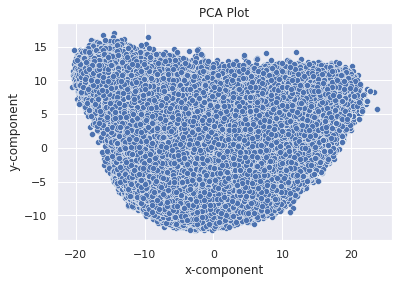

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
df = pd.DataFrame(pca_embedding,columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=df)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("PCA Plot")
plt.show()

In [ ]:
data_labels = np.array([item[-2] for item in ed.crawler.metadata["train"]["crawl"]])

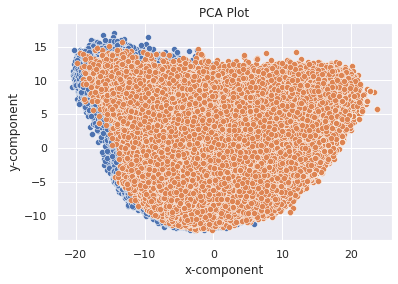

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
df_fake = pd.DataFrame(pca_embedding[data_labels==0],columns=["x-component", "y-component"])
df_true = pd.DataFrame(pca_embedding[data_labels==1],columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=df_true)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
sns.scatterplot(x="x-component", y="y-component", data=df_fake)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("PCA Plot")
plt.show()

#### Some extras for tSNE for labeling points

In [ ]:
# For this to work, you need to rerun the ed from the beginning of this section, because it is reset afterwards to get experiment name
labels = np.array([item[3] for item in ed.crawler.metadata["train"]["crawl"]])
fiveg = np.array(["5g" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])
hydroxy = np.array(["hydro" in item[0].strip().lower() or "chloro" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])
bioweapon = np.array(["bio" in item[0].strip().lower() or "weapon" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])
vaccine = np.array(["vaccine" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])
guidance = np.array(["guidance" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])
masks = np.array(["mask" in item[0].strip().lower() for item in ed.crawler.metadata["train"]["crawl"]])

In [ ]:
embedding.shape

(3839, 2)

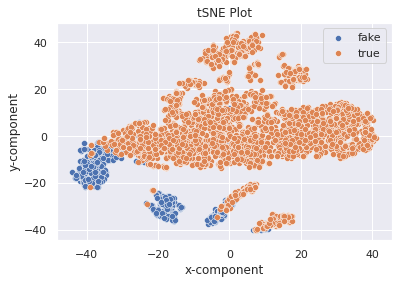

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
fake = pd.DataFrame(embedding[labels==0],columns=["x-component", "y-component"])
true = pd.DataFrame(embedding[labels==1],columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=fake, label="fake")
sns.scatterplot(x="x-component", y="y-component", data=true, label="true")
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
ax1.legend()
plt.title("tSNE Plot")
plt.show()

In [ ]:
embedding[(embedding[:,0]>-15) & (embedding[:,0]<0)]

array([[-13.5100978 ,  -6.69404435],
       [ -1.10841534,   9.68402638],
       [-11.57595265, -21.48711515],
       ...,
       [-12.77033182,  34.53972   ],
       [ -8.68996042,  47.64642537],
       [ -9.4583767 ,  34.72681009]])

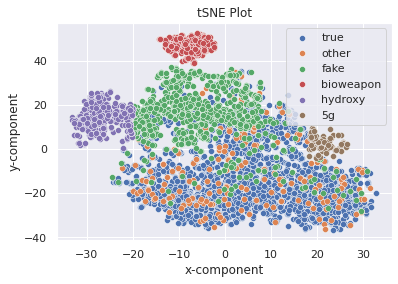

In [ ]:
bounds = [("bioweapon", [-15, 0, 38, 55]),
          ("hydroxy", [-35, -20, 0, 28]),
          ("5g", [18, 30, -4, 10])]

fdfs = [
    (lname, pd.DataFrame(
        embedding[(embedding[:,0]>= bound[0]) & (embedding[:,0]<= bound[1]) & (embedding[:,1]>= bound[2]) & (embedding[:,1]<= bound[3])], columns=["x-component", "y-component"]
    ))
    for lname, bound in bounds
]


import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
fake1 = pd.DataFrame(embedding[labels==0][200:],columns=["x-component", "y-component"])
fake2 = pd.DataFrame(embedding[labels==0][:200],columns=["x-component", "y-component"])
true = pd.DataFrame(embedding[labels==1],columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=fake1, label="true")
sns.scatterplot(x="x-component", y="y-component", data=fake2, label="other")
sns.scatterplot(x="x-component", y="y-component", data=true, label="fake")
for lname, fdf in fdfs:
  sns.scatterplot(x="x-component", y="y-component", data=fdf, label=lname)

             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
ax1.legend()
plt.title("tSNE Plot")
plt.show()

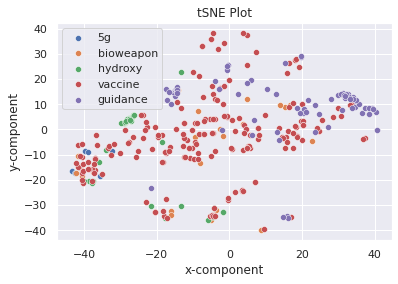

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
fiveg_ = pd.DataFrame(embedding[fiveg==1],columns=["x-component", "y-component"])
bioweapon_ = pd.DataFrame(embedding[bioweapon==1],columns=["x-component", "y-component"])
hydroxy_ = pd.DataFrame(embedding[hydroxy==1],columns=["x-component", "y-component"])
vaccine_ = pd.DataFrame(embedding[vaccine==1],columns=["x-component", "y-component"])
guidance_ = pd.DataFrame(embedding[guidance==1],columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=fiveg_, label="5g")
sns.scatterplot(x="x-component", y="y-component", data=bioweapon_, label="bioweapon")
sns.scatterplot(x="x-component", y="y-component", data=hydroxy_, label="hydroxy")
sns.scatterplot(x="x-component", y="y-component", data=vaccine_, label="vaccine")
sns.scatterplot(x="x-component", y="y-component", data=guidance_, label="guidance")
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
ax1.legend()
plt.title("tSNE Plot")
plt.show()

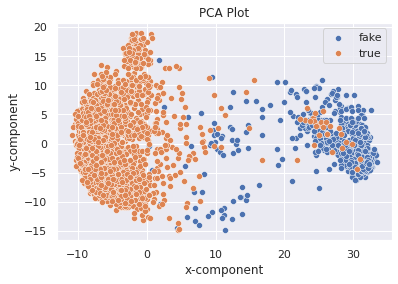

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
fake_pca = pd.DataFrame(pca_embedding[labels==0],columns=["x-component", "y-component"])
true_pca = pd.DataFrame(pca_embedding[labels==1],columns=["x-component", "y-component"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=fake_pca, label="fake")
sns.scatterplot(x="x-component", y="y-component", data=true_pca, label="true")
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
ax1.legend()
plt.title("PCA Plot")
plt.show()

In [ ]:
pca_embedding1 = np.load("fnc-expert-fakeddit-rwm_1_albertv2-mlm_seq_fakeddit_pca.npy")
pca_embedding2 = np.load("fnc-expert-fakeddit-kwm_att_1_albertv2-mlm_seq_fakeddit_pca.npy")
pca_embedding3 = np.load("fnc-expert-fakeddit-kwrwm_att_1_albertv2-mlm_seq_fakeddit_pca.npy")
pca_embedding4 = np.load("fnc-expert-fakeddit-rtm_1_albertv2-mlm_seq_fakeddit_pca.npy")
pca_embedding5 = np.load("fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit_pca.npy")

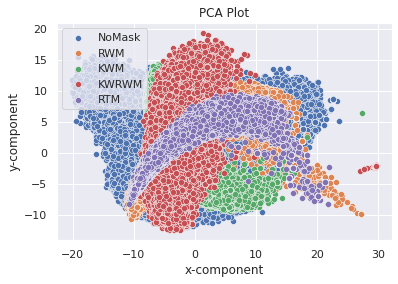

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
df1 = pd.DataFrame(pca_embedding1,columns=["x-component", "y-component"])
df2 = pd.DataFrame(pca_embedding2,columns=["x-component", "y-component"])
df3 = pd.DataFrame(pca_embedding3,columns=["x-component", "y-component"])
df4 = pd.DataFrame(pca_embedding4,columns=["x-component", "y-component"])
df5 = pd.DataFrame(pca_embedding5,columns=["x-component", "y-component"])
fig, ax = plt.subplots() # initializes figure and plots
sns.scatterplot(x="x-component", y="y-component", data=df5)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
sns.scatterplot(x="x-component", y="y-component", data=df1)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
sns.scatterplot(x="x-component", y="y-component", data=df2)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
sns.scatterplot(x="x-component", y="y-component", data=df3)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
sns.scatterplot(x="x-component", y="y-component", data=df4)
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)

ax.legend(["NoMask", "RWM", "KWM", "KWRWM", "RTM", ], loc='upper left')
plt.title("PCA Plot")
plt.show()

### Cross-domain plotting

In [ ]:
# First copy over the relevant files, i.e. the h5 files of features.
import shutil, glob, os, h5py, numpy as np
fl_list = glob.glob("./drive/MyDrive/Projects/SemanticMasking/*.h5")
for fl_ in fl_list:
  flbase = os.path.basename(fl_)
  shutil.copy2(fl_, flbase)

In [ ]:
nomask = "fakeddit_nomask_efnd_all_albert-base-v2.h5"
rtm = "fakeddit_rtm_efnd_all_albert-base-v2.h5"
rwm = "fakeddit_rwm_efnd_all_albert-base-v2.h5"
kwm = "fakeddit_kwm_att_efnd_all_albert-base-v2.h5"
kwrwm = "fakeddit_kwrwm_att_efnd_all_albert-base-v2.h5"
fakeddit_nomask = "fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit.h5"
fakeddit_kwm = "fnc-expert-fakeddit-kwm_att_1_albertv2-mlm_seq_fakeddit.h5"
fakeddit_kwrwm = "fnc-expert-fakeddit-kwrwm_att_1_albertv2-mlm_seq_fakeddit.h5"
fakeddit_rtm = "fnc-expert-fakeddit-rtm_1_albertv2-mlm_seq_fakeddit.h5"
fakeddit_rtm = "fnc-expert-fakeddit-rwm_1_albertv2-mlm_seq_fakeddit.h5"

def get_features(fls_arr):
  import h5py
  nparrs = [None]*len(fls_arr)
  for idx, pth in enumerate(fls_arr):
    data = h5py.File(pth, 'r')
    nparrs[idx] = data["features"]
  return nparrs

In [ ]:
nparrs = get_features([fakeddit_kwm, nomask, rwm, kwm, kwrwm])
resp = np.concatenate(nparrs,axis=0)
embedding, xtsne = _tSNE(resp, random_state = 26640933)
npsizes = [item.shape[0] for item in nparrs]

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
embedding_tshape = embedding.shape[0]
arr_baseshape = nparrs[0].shape[0]
nummappings = embedding_tshape / arr_baseshape
dflist = []
pshape = 0
for idx in range(len(npsizes)):
  dflist.append(pd.DataFrame(embedding[pshape:pshape+npsizes[idx]],columns=["x-component", "y-component"]))
  pshape+=npsizes[idx]

colors = ["blue", "magenta", "darkgreen", "purple", "yellow"]
for idx, df in enumerate(dflist[1:]):
  fig, ax1 = plt.subplots() # initializes figure and plots
  sns.scatterplot(x="x-component", y="y-component", data=dflist[0], color=colors[0])
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
  sns.scatterplot(x="x-component", y="y-component", data=df, color=colors[idx+1])
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
  plt.title("tSNE Plot")
  plt.show()

In [ ]:
nparrs = get_features([fakeddit_kwm, nomask, rwm, kwm, kwrwm])
embedding, xpca = _PCA(nparrs[0], random_state = 26640933)
fitted_arrs = [xpca.transform(item) for item in nparrs]

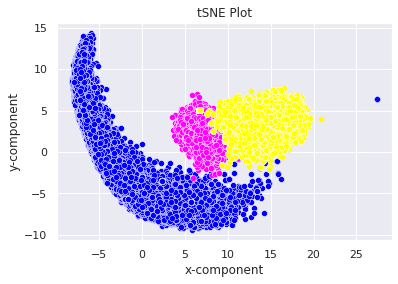

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
embedding_tshape = embedding.shape[0]
dflist = []
for idx in range(len(fitted_arrs)):
  dflist.append(pd.DataFrame(fitted_arrs[idx],columns=["x-component", "y-component"]))
fig, ax1 = plt.subplots() # initializes figure and plots
colors = ["blue", "magenta", "darkgreen", "purple", "yellow", "black"]
for idx, df in enumerate(dflist):
  sns.scatterplot(x="x-component", y="y-component", data=df, color=colors[idx])
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("tSNE Plot")
plt.show()

### Existing tsne plotting

In [ ]:
# First copy over the relevant files, i.e. the h5 files of features.
import shutil, glob, os, h5py, numpy as np
fl_list = glob.glob("./drive/MyDrive/Projects/SemanticMasking/*tsne.npy")
for fl_ in fl_list:
  flbase = os.path.basename(fl_)
  shutil.copy2(fl_, flbase)
fl_list = glob.glob("./drive/MyDrive/Projects/SemanticMasking/*pca.npy")
for fl_ in fl_list:
  flbase = os.path.basename(fl_)
  shutil.copy2(fl_, flbase)

In [ ]:
fakeddit_nomask_tsne =  "fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit_tsne.npy"
fakeddit_rtm_tsne = "fnc-expert-fakeddit-rtm_1_albertv2-mlm_seq_fakeddit_tsne.npy"
fakeddit_rwm_tsne = "fnc-expert-fakeddit-rwm_1_albertv2-mlm_seq_fakeddit_tsne.npy"
fakeddit_kwm_tsne = "fnc-expert-fakeddit-kwm_att_1_albertv2-mlm_seq_fakeddit_tsne.npy"
fakeddit_kwrwm_tsne = "fnc-expert-fakeddit-kwrwm_att_1_albertv2-mlm_seq_fakeddit_tsne.npy"
efnd_nomask_tsne = "fakeddit_nomask_efnd_all_albert-base-v2_tsne.npy"
efnd_rtm_tsne = "fakeddit_rtm_efnd_all_albert-base-v2_tsne.npy"
efnd_rwm_tsne = "fakeddit_rwm_efnd_all_albert-base-v2_tsne.npy"
efnd_kwm_tsne = "fakeddit_kwm_att_efnd_all_albert-base-v2_tsne.npy"
efnd_kwrwm_tsne = "fakeddit_kwrwm_att_efnd_all_albert-base-v2_tsne.npy"
fakeddit_nomask_pca =  "fnc-expert-fakeddit-nomask_1_albert-base-v2_fakeddit_pca.npy"
fakeddit_rtm_pca = "fnc-expert-fakeddit-rtm_1_albertv2-mlm_seq_fakeddit_pca.npy"
fakeddit_rwm_pca = "fnc-expert-fakeddit-rwm_1_albertv2-mlm_seq_fakeddit_pca.npy"
fakeddit_kwm_pca = "fnc-expert-fakeddit-kwm_att_1_albertv2-mlm_seq_fakeddit_pca.npy"
fakeddit_kwrwm_pca = "fnc-expert-fakeddit-kwrwm_att_1_albertv2-mlm_seq_fakeddit_pca.npy"
efnd_nomask_pca = "fakeddit_nomask_efnd_all_albert-base-v2_pca.npy"
efnd_rtm_pca = "fakeddit_rtm_efnd_all_albert-base-v2_pca.npy"
efnd_rwm_pca = "fakeddit_rwm_efnd_all_albert-base-v2_pca.npy"
efnd_kwm_pca = "fakeddit_kwm_att_efnd_all_albert-base-v2_pca.npy"
efnd_kwrwm_pca = "fakeddit_kwrwm_att_efnd_all_albert-base-v2_pca.npy"

toplot = [fakeddit_nomask_pca, efnd_rwm_pca]

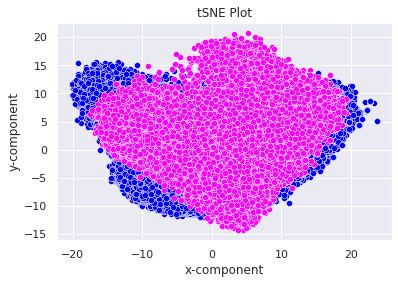

In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
embedding_tshape = embedding.shape[0]
dflist = []
for idx in range(len(toplot)):
  dflist.append(pd.DataFrame(np.load(toplot[idx]),columns=["x-component", "y-component"]))
fig, ax1 = plt.subplots() # initializes figure and plots
colors = ["blue", "magenta", "darkgreen", "purple", "yellow", "black"]
for idx, df in enumerate(dflist):
  sns.scatterplot(x="x-component", y="y-component", data=df, color=colors[idx])
             #palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("tSNE Plot")
plt.show()

## Proxy Estimation

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class TrainingFeaturesGenerator(HFDeploy):
  def output_setup(self, **kwargs):
    output_file = kwargs.get("feature_file", "training_features")
    self.output_file = output_file + ".h5"
    if os.path.exists(self.output_file):
      os.remove(self.output_file)
    self.writer = h5py.File(self.output_file, "w")  #we will delete old training features file
    self.written = False
    self.prev_idx = -1
    
  def output_step(self, logits, features: torch.LongTensor, secondary): 
    if self.written:
        feats = features.cpu().numpy()
        self.writer["features"].resize((self.writer["features"].shape[0] + feats.shape[0]), axis=0)
        self.writer["features"][-feats.shape[0]:] = feats        
    else:   # First time writing -- we will need to create the dataset.
        self.writer.create_dataset("features", data=features.cpu().numpy(), compression = "gzip", chunks=True, maxshape=(None,features.shape[1]))
        self.written = True

    if self.writer["features"].shape[0]%5000 > self.prev_idx:
        self.logger.debug("Chunked %i lines in deployment output %s"%(self.writer["features"].shape[0], self.output_file))
        self.prev_idx = self.writer["features"].shape[0]%5000

  def end_of_epoch(self, epoch: int):
      self.writer.close()

In [ ]:
ed = EdnaDeploy(config=["./GLAMOR/profiles/FNC/experts/configs/config_base_plugin_deploy.yml",
                      crawler_variant,
                      model_variant],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.DRIVE_BACKUP", True),
                 ("SAVE.LOG_BACKUP", False),
                 ("MODEL.MODEL_BASE", model_backbone),
                 ("SAVE.SAVE_FREQUENCY", 1),
                 ("TRANSFORMATION.BATCH_SIZE", 128),
             ],
             dataloader_mode = "train")
ed.cfg.DATAREADER.CRAWLER_ARGS = dataset_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = False
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["feature_file"] = "training"


ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm



ed.add(crawler_file)
ed.addDeploymentClass(TrainingFeaturesGenerator)

11:44:16 Adding a crawler, from /content/GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py, with inferred name NELACrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-nela-elections-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, nela_elections_2020
Injected key-value pair:  SAVE.DRIVE_BACKUP, True
Injected key-value pair:  SAVE.LOG_BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  SAVE.SAVE_FREQUENCY, 1
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 128
Log file exists at fnc-expert-nela-elections-nomask-v2-albert-base-v2-nela_elections_2020/fnc-expert-nela-elections-nomask-v2-albert-base-v2-nela_elections_2020-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py.NELACrawler'>, from file: /content/GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py


In [ ]:
ed.apply(skip_model_summary=True)

11:47:38 ****************************************
11:47:38 
11:47:38 
11:47:38 Using the following configuration:
11:47:38 DATAREADER:
  CRAWLER_ARGS:
    data_folder: Data
    sub_folder: nela-elections-2020
  DATAREADER: HFReader
  DATASET_ARGS:
    annotation_idxs:
    - 1
    - 2
    classificationclass:
    - fnews
    data_shuffle: false
    keytoken_mask: false
    keyword_mask: false
    keywords:
    - covid
    - corona
    - mask
    - wuhan
    - n95
    - sars
    - monkey
    - pandemic
    - social
    - quarantin
    - virus
    - infect
    - lock
    - ppe
    - variant
    - vaccine
    - travel
    - omicron
    - ivermectin
    - plandemic
    - 5g
    - gates
    - hoax
    - bioweapon
    - bat
    - fauci
    label_idxs:
    - 3
    masking: false
    maxlen: 512
    mlm_probability: 0.15
    shard_replace: false
    shardcache: true
    shardname: fnc-nela-shard
    shardpath: datashard-artifacts
    shardsize: 20000
    shuffle: false
    token_mask: false
   

Building Transforms
Building Dataset


11:47:48 Generated test data/query generator
11:47:48 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

11:47:53 Starting deployment
11:47:53 Logging to:	fnc-expert-nela-elections-nomask-v2-albert-base-v2-nela_elections_2020-logger.log
11:47:53 Loading a model from saved epoch 3
11:47:53 Loading model from drive backup.
11:47:53 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-expert-nela-elections-nomask-v2-albert-base-v2-nela_elections_2020/fnc-expert-nela-elections-nomask-v2_epoch3.pth
11:47:53 Looking for model plugins from drive backup.
11:47:53 No plugins found at ./drive/MyDrive/Projects/FNC/Models/fnc-expert-nela-elections-nomask-v2-albert-base-v2-nela_elections_2020/fnc-expert-nela-elections-nomask-v2_plugins.pth
11:47:53 Setting up plugin hooks. Plugins will fire during:  warmup
11:47:53 Executing deployment for  1 epochs
11:47:53 Starting epoch 0
11:53:50 Performing save at epoch 1
11:53:50 Saving model plugins.
11:53:50 No plugins to save
11:53:50 Executing end of epoch steps
11:53:50 Completed deployment task.


## Optimal Proxies Estimation

In [ ]:
def cluster_sweep(features_file, batch_size, max_iters, cluster_range):
  import h5py, time
  from sklearn.cluster import MiniBatchKMeans
  from sklearn.metrics import silhouette_score
  inertia = []
  silh = []
  data = h5py.File(features_file, 'r')
  data_size = data['features'].shape[0]
  
  for k in cluster_range:
    print("Starting sweep for k={kval}, with {iters} iterations".format(kval=k, iters=max_iters))
    kmeans = MiniBatchKMeans(n_clusters = k, random_state = 23465356, batch_size = batch_size)
    stime = time.time()
    for iters in range(max_iters):
      for i in range(0, data_size, batch_size):
          current_data = data['features'][i:i+batch_size]
          kmeans.partial_fit(current_data)
      if iters%10 == 0:
        etime = round(time.time() - stime, 2)
        print("\t[{elapse} s] -- Completed {iters} iterations".format(iters=iters, elapse = etime))
        stime = time.time()
    #sscore = silhouette_score(data["features"], kmeans.predict(data["features"]))
    print("\tCompeted MBKM for k={kval}, with inertia: {inertia}".format(kval=k, inertia = kmeans.inertia_))
    inertia.append(kmeans.inertia_)
    #silh.append(sscore)
  return inertia, silh

In [ ]:
cluster_range = [2,5,10,15,20,30,40,50,75,100]
inertia, silh = cluster_sweep(
    features_file = "training.h5",
    batch_size=256,
    max_iters = 25,
    cluster_range = cluster_range
)

Starting sweep for k=2, with 25 iterations
	[4.06 s] -- Completed 0 iterations
	[36.46 s] -- Completed 10 iterations
	[36.47 s] -- Completed 20 iterations
	Competed MBKM for k=2, with inertia: 2786.618408203125
Starting sweep for k=5, with 25 iterations
	[3.74 s] -- Completed 0 iterations
	[37.38 s] -- Completed 10 iterations
	[37.31 s] -- Completed 20 iterations
	Competed MBKM for k=5, with inertia: 1075.57763671875
Starting sweep for k=10, with 25 iterations
	[3.8 s] -- Completed 0 iterations
	[37.34 s] -- Completed 10 iterations
	[38.23 s] -- Completed 20 iterations
	Competed MBKM for k=10, with inertia: 664.6404418945312
Starting sweep for k=15, with 25 iterations
	[3.91 s] -- Completed 0 iterations
	[38.4 s] -- Completed 10 iterations
	[38.19 s] -- Completed 20 iterations
	Competed MBKM for k=15, with inertia: 584.6007080078125
Starting sweep for k=20, with 25 iterations
	[3.88 s] -- Completed 0 iterations
	[38.19 s] -- Completed 10 iterations
	[39.84 s] -- Completed 20 iterations

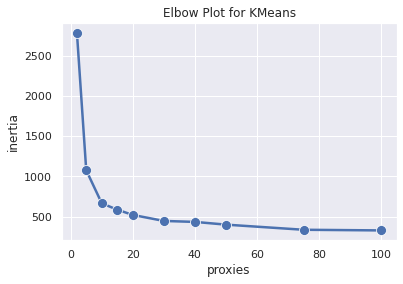

+-----------+-----------+
|   proxies |   inertia |
|-----------+-----------|
|         2 |  2786.62  |
|         5 |  1075.58  |
|        10 |   664.64  |
|        15 |   584.601 |
|        20 |   519.635 |
|        30 |   445.061 |
|        40 |   432.955 |
|        50 |   398.999 |
|        75 |   335.182 |
|       100 |   327.108 |
+-----------+-----------+


In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
datadf=pd.DataFrame(list(zip(cluster_range,inertia)), columns=["proxies", "inertia"])
fig, ax1 = plt.subplots() # initializes figure and plots
sns.lineplot(x="proxies", y="inertia", data=datadf, 
             palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("Elbow Plot for KMeans")
plt.show()
print(tabulate.tabulate(datadf, headers="keys", showindex=False, tablefmt="psql"))

## Generating Plugins for a trained model

We will need to generate the following plugins:
- l2-kmp
- cos-kmp
- high-density set
- randomized lipschitz
- logit confidence

In [ ]:
#! rm -rf -- test-datashard-artifacts
#! rm -rf -- train-datashard-artifacts

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/experts/configs/config_base_plugin_deploy.yml",
                      crawler_variant,
                      model_variant, 
                      "./EdnaML/profiles/FNC/experts/configs/plugin_base.yml",
                      "./EdnaML/profiles/SemanticMasking/save_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.DRIVE_BACKUP", False),  # For this deployment, we need no backup. storage_mode is download_only as well
                 ("MODEL.MODEL_BASE", model),
                 ("MODEL.MODEL_VERSION", version),
                 ("SAVE.BACKUP.FREQUENCY", save_frequency),
                 ("SAVE.BACKUP.FREQUENCY_STEP", step_save_frequency),
                  ("TRANSFORMATION.BATCH_SIZE", 32)
             ],
             dataloader_mode = "train")

ed.cfg.DATAREADER.CRAWLER_ARGS = crawler_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = shard_replace
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False


ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

# PROXIES
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["alpha"] = k_alpha
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["alpha"] = k_alpha
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["alpha"] = l_alpha

if variant == "mlm_seq":
  ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["classifier_access"] = "cls_head"
  ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["classifier_access"] = "cls_head"
  ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["classifier_access"] = "cls_head"


ed.add(crawler_file)

[INFO 03:31:03] Generated logger object with experiment key fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news
[INFO 03:31:03] Generated logger object with experiment key fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news
[DEBUG 03:31:03] [ed]Resetting declarative queues.
[INFO 03:31:03] [ed]Initialized empty Context Object
[INFO 03:31:03] [ed]Adding a crawler, from /content/EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py, with inferred name MiDASCrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-efnd-kwrwm_att
Injected key-value pair:  SAVE.MODEL_BACKBONE, albertv2-mlm_seq
Injected key-value pair:  SAVE.MODEL_QUALIFIER, coaid_news
Injected key-value pair:  SAVE.DRIVE_BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  MODEL.MODEL_VERSION, 1
Injected key-value pair:  SAVE.BACKUP.FREQUENCY, 1
Injected key-value pair:  SAVE.BACKUP.FREQUENCY_STEP, 0
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 32
Registering a crawler: <class './EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py.MiDASCrawler'>, from file: /content/EdnaML/profiles/FNC/experts/crawlers/efnd-crawler.py


In [ ]:
ed.apply(skip_model_summary=True, new_run = False, tracking_run = 0)
#ed.apply(skip_model_summary=True, new_run = True)

[INFO 03:31:03] [ed][APPLY] Building StorageManager
[DEBUG 03:31:03] [StorageManager] Initializing StorageManager
[DEBUG 03:31:03] [StorageManager] 	using experiment_key:      	fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news
[DEBUG 03:31:03] [StorageManager] 	with storage_manager_mode: 	download_only
[DEBUG 03:31:03] [StorageManager] 	with storage_trigger_mode: 	loose
[DEBUG 03:31:03] [StorageManager] 	with storage_mode:         	local
[DEBUG 03:31:03] [StorageManager] 	with backup_mode:          	hybrid
[DEBUG 03:31:03] [StorageManager] 	Using local save directory: 	fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-coaid_news
[DEBUG 03:31:03] [StorageManager] 	Using file basename: 	experiment
[DEBUG 03:31:03] [StorageManager] Generated `ednaml-local-storage-reserved` LocalStorage object
[DEBUG 03:31:03] [StorageManager] Generated EpochTrigger checks
[DEBUG 03:31:03] [StorageManager] Generated StepTrigger checks
[INFO 03:31:03] [ed][APPLY] Adding Storages
[INFO 03:31:03] [ed]Loaded

Building Transforms


[INFO 03:31:09] [Mode `train`] Will look in path [train-datashard-artifacts] for shards `fnc-efnd-shard-[e].pt`
[INFO 03:31:09] Deleting existing shards
[INFO 03:31:09] Creating shardpath train-datashard-artifacts
[INFO 03:31:09] Generating shards
[INFO 03:31:09] Generating shards


Building Dataset


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]
[INFO 03:31:11] Obtained 1 shards
[DEBUG 03:31:11] Loading shard train-datashard-artifacts/fnc-efnd-shard-0.pt
[INFO 03:31:11] Refreshing token masks for loaded shard
[DEBUG 03:31:11] Refreshing mask ids
[DEBUG 03:31:11] Performing random word masking
[INFO 03:31:22] Generated test data/query generator
[INFO 03:31:22] [ed][APPLY] Building model
[INFO 03:31:22] [ed]Loaded hf_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[INFO 03:31:24] [ed]Finished instantiating model with HFMLMSequenceModel architecture
[INFO 03:31:24] [ed]Adding plugins after constructing model
[INFO 03:31:24] Added plugin FastKMP-l2
[INFO 03:31:24] Added plugin FastKMP-cos
[INFO 03:31:24] Added

In [ ]:
ed.deploy()

[DEBUG 03:31:26] `continue_epoch` is provided. Checking validity in remote and local Storage with artifact MODEL
[DEBUG 03:31:26] `continue_epoch` value of 0 is valid. Checking `continue_step`.
[DEBUG 03:31:26] `continue_step` is not provided or not valid. Getting latest step saved in Epoch 0 in remote and local Storage
[DEBUG 03:31:26] Found latest `continue_step` 480
[INFO 03:31:26] Using provided epoch/step pair 0/480.
[INFO 03:31:26] Using ERSKey <fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news, 0, model-0-480>
[INFO 03:31:26] Starting deployment. with `continue_epoch` 0 and `continue_step` 480
[INFO 03:31:26] `model_build` is True or model may not be built. Checking.
[INFO 03:31:26] Weights have already been loaded into model. Skipping loading of epoch-specific weights from Epoch 0 Step 480
[INFO 03:31:26] Switching to latest ERSKey `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news, 0, model-4-480>`
[INFO 03:31:26] Incremented latest ERSKey to `<fnc-expert-efnd-kwr

Starting KMeans for k=30, with 30 iterations
	[0.24 s] -- Completed 0 iterations
	[0.59 s] -- Completed 5 iterations
	[0.59 s] -- Completed 10 iterations
	[0.58 s] -- Completed 15 iterations
	[0.59 s] -- Completed 20 iterations
	[0.58 s] -- Completed 25 iterations
	Competed MBKM for k=30, with inertia: 2124.90869140625
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=30, with 30 iterations
	[0.18 s] -- Completed 0 iterations
	[0.58 s] -- Completed 5 iterations
	[0.59 s] -- Completed 10 iterations
	[0.59 s] -- Completed 15 iterations
	[0.59 s] -- Completed 20 iterations
	[0.59 s] -- Completed 25 iterations
	Competed MBKM for k=30, with inertia: 2124.90869140625
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=30, with 30 iterations
	[0.19 s] -- Completed 0 iterations
	[0.58 s] -- Completed 5 iterations
	[0.58 s] -- Completed 10 iterations
	[0.58 s] -- Completed 15 iterations
	[0.6 s] -- C

[INFO 03:32:03] RandomizedLipschitz starting Lipschitz stage
[DEBUG 03:32:03] Checking epoch save status at Epoch 0
[DEBUG 03:32:03] Attempting upload of artifact `model` at epoch 0 / step 0
[DEBUG 03:32:03] Not saving model in Deployment
[DEBUG 03:32:03] Attempting upload of artifact `plugin` at epoch 0 / step 0
[DEBUG 03:32:03] Saved the following plugins: dict_keys(['FastKMP-l2', 'FastKMP-cos', 'FRL-midas', 'logit-confidence'])
[DEBUG 03:32:03] [StorageManager] Uploading ./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-coaid_news/0/experiment_epoch0_step0_plugin.pth into storage GoogleDrive, with ERSKey `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news, 0, plugin-0-0>`
[DEBUG 03:32:03] Attempting upload of artifact `log` at epoch 0 / step 0
[DEBUG 03:32:03] Not saving logs in Deployment
[DEBUG 03:32:03] Attempting upload of artifact `metric` at epoch 0 / step 0
[DEBUG 03:32:03] [StorageManager] Could not find any file for ERSKey `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_

Completed High Density threshold estimation


 98%|█████████▊| 119/122 [00:13<00:00,  6.25it/s][DEBUG 03:32:17] Loading shard train-datashard-artifacts/fnc-efnd-shard-0.pt
[DEBUG 03:32:17] Refreshing mask ids
 99%|█████████▉| 121/122 [00:14<00:00,  6.58it/s][DEBUG 03:32:17] Performing random word masking
[INFO 03:32:28] RandomizedLipschitz has completed Lipschitz stage. Computing L values.
[DEBUG 03:32:28] Checking epoch save status at Epoch 1
[DEBUG 03:32:28] Attempting upload of artifact `model` at epoch 1 / step 0
[DEBUG 03:32:28] Not saving model in Deployment
[DEBUG 03:32:28] Attempting upload of artifact `plugin` at epoch 1 / step 0
[DEBUG 03:32:28] Saved the following plugins: dict_keys(['FastKMP-l2', 'FastKMP-cos', 'FRL-midas', 'logit-confidence'])
[DEBUG 03:32:28] [StorageManager] Uploading ./fnc-expert-efnd-kwrwm_att-v1-albertv2-mlm_seq-coaid_news/0/experiment_epoch1_step0_plugin.pth into storage GoogleDrive, with ERSKey `<fnc-expert-efnd-kwrwm_att_1_albertv2-mlm_seq_coaid_news, 0, plugin-1-0>`
[DEBUG 03:32:28] Attemptin

In [ ]:
import numpy as np
print("Threshold:\t{thresholds:3.3f} \nMean: \t\t{mean:.3f}\nSTD:\t\t{std:.3f}".format(thresholds = np.max(ed.model.plugins["FRL-midas"].proxy_lipshitz), 
                                                                              mean = np.mean(ed.model.plugins["FRL-midas"].proxy_lipshitz),
                                                                              std = np.std(ed.model.plugins["FRL-midas"].proxy_lipshitz)))

Threshold:	0.065 
Mean: 		0.044
STD:		0.009


In [ ]:
import numpy as np
print("Threshold:\t{thresholds:.3f} \nMean: \t\t{mean:.3f}\nSTD:\t\t{std:.3f}".format(thresholds = np.max(ed.model.plugins["FRL-midas"].proxy_smooth_lipshitz), 
                                                                              mean = np.mean(ed.model.plugins["FRL-midas"].proxy_smooth_lipshitz),
                                                                              std = np.std(ed.model.plugins["FRL-midas"].proxy_smooth_lipshitz)))

Threshold:	0.053 
Mean: 		0.030
STD:		0.012


## Use Plugins (in-Domain Testing)

### Applying

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class PluginsTestDeploy(HFDeploy):
  def deploy_step(self, batch):
    batch = tuple(item.cuda() for item in batch)
    (
        all_input_ids,
        all_attention_mask,
        all_token_type_ids,
        all_masklm,
        all_annotations,
        all_labels
    ) = batch
    outputs = self.model(
        all_input_ids,
        token_type_ids=all_token_type_ids,
        attention_mask=all_attention_mask,
        output_attentions = True,
        output_hidden_states = True,
        secondary_inputs=all_annotations       # NOT for HFTrainer! because it only expects specific inputs!
    )

    logits = outputs[0]
    secondaries = outputs[2]
    
    return logits, all_labels, secondaries
  def output_setup(self, **kwargs):
    self.ofile = kwargs.get("output_filename")
    self.oobj = open(self.ofile, "w")
    self.oobj.write(",".join([
      "gt_label",
      "predicted_label",
      "l2_dist",
      "l2_hdthreshold",
      "l2_proxylabels",
      "cos_dist",
      "cos_hdthreshold",
      "cos_proxylabels",
      "l_score",
      "smooth_l_score",
      "l_threshold",
      "smooth_l_threshold",
      "l_proxylabel",
      "logit_raw",
      "logit_threshold"
      ])+"\n")
  def output_step(self, logits, all_labels, secondary):
    # outputs is a list, where the post is in outputs[2], I think????
    # In any case, we need to check ouputs[2] to get the threshold...
    predicted_label = torch.argmax(torch.nn.functional.softmax(logits.cpu(), dim=1), dim=1).tolist()
    l2_dist = secondary[2]["FastKMP-l2"]["distance"].to(torch.float32).tolist()
    l2_hdthreshold = secondary[2]["FastKMP-l2"]["threshold"].to(torch.float32).tolist()
    l2_proxylabels = secondary[2]["FastKMP-l2"]["proxy_labels"].to(torch.float32).tolist()
    
    cos_dist = secondary[2]["FastKMP-cos"]["distance"].to(torch.float32).tolist()
    cos_hdthreshold = secondary[2]["FastKMP-cos"]["threshold"].to(torch.float32).tolist()
    cos_proxylabels = secondary[2]["FastKMP-cos"]["proxy_labels"].to(torch.float32).tolist()

    l_score = secondary[2]["FRL-midas"]["l_score"]
    smooth_l_score = secondary[2]["FRL-midas"]["smooth_l_score"]
    l_threshold = secondary[2]["FRL-midas"]["l_threshold"]
    smooth_l_threshold = secondary[2]["FRL-midas"]["smooth_l_threshold"]
    l_proxylabel = secondary[2]["FRL-midas"]["proxy_label"].to(torch.float32).tolist()

    logit_raw = secondary[2]["logit-confidence"]["logit"].to(torch.float32).tolist()
    logit_threshold = secondary[2]["logit-confidence"]["logit_threshold"].to(torch.float32).tolist()
    gt_label = all_labels[:,0].tolist()

    output_list = [",".join(map(str,item)) for item in zip(
      gt_label,
      predicted_label,
      l2_dist,
      l2_hdthreshold,
      l2_proxylabels,
      cos_dist,
      cos_hdthreshold,
      cos_proxylabels,
      l_score,
      smooth_l_score,
      l_threshold,
      smooth_l_threshold,
      l_proxylabel,
      logit_raw,
      logit_threshold
      )]
    self.oobj.write("\n".join(output_list)+"\n")

  def end_of_epoch(self, epoch: int):
      self.oobj.close()

In [ ]:
ed = EdnaDeploy(config=["./GLAMOR/profiles/FNC/experts/configs/config_base_plugin_deploy.yml",
                      crawler_variant,
                      model_variant, 
                      "./GLAMOR/profiles/FNC/experts/configs/plugin_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.DRIVE_BACKUP", False),
                 ("MODEL.MODEL_BASE", model_backbone),
                 ("SAVE.SAVE_FREQUENCY", 5),
                 ("DEPLOYMENT.EPOCHS", 1),
                 ("DEPLOYMENT.PLUGIN.HOOKS", "activated"),
                 ("TRANSFORMATION.BATCH_SIZE", 32),
                 ("DEPLOYMENT.PLUGIN.HOOKS", "activated"),
             ],
             dataloader_mode = "train")
ed.cfg.DATAREADER.CRAWLER_ARGS = dataset_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = False
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["output_filename"] = ed.saveMetadata.MODEL_SAVE_FOLDER+".csv"

ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

# PROXIES
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["proxies"] = proxy

ed.add(crawler_file)
ed.addDeploymentClass(PluginsTestDeploy)

19:20:30 Adding a crawler, from /content/GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py, with inferred name MiDASCrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-efnd-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, cov19_fn_text
Injected key-value pair:  SAVE.DRIVE_BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  SAVE.SAVE_FREQUENCY, 5
Injected key-value pair:  DEPLOYMENT.EPOCHS, 1
Injected key-value pair:  DEPLOYMENT.PLUGIN.HOOKS, activated
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 32
Injected key-value pair:  DEPLOYMENT.PLUGIN.HOOKS, activated
Log file exists at fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py.MiDASCrawler'>, from file: /content/GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py


In [ ]:
ed.apply(skip_model_summary=True)

19:20:30 ****************************************
19:20:30 
19:20:30 
19:20:30 Using the following configuration:
19:20:30 DATAREADER:
  CRAWLER_ARGS:
    data_folder: Data
    include:
    - cov19_fn_text
  DATAREADER: HFReader
  DATASET_ARGS:
    annotation_idxs:
    - 1
    - 2
    classificationclass:
    - fnews
    data_shuffle: false
    keytoken_mask: false
    keyword_mask: false
    keywords: []
    label_idxs:
    - 3
    masking: false
    maxlen: 512
    mlm_probability: 0.15
    shard_replace: false
    shardcache: true
    shardname: fnc-efnd-shard
    shardpath: datashard-artifacts
    shardsize: 20000
    shuffle: false
    token_mask: false
    word_mask: false
  GENERATOR: null
  GENERATOR_ARGS:
    from_pretrained: albert-base-v2
    tokenizer: HFAutoTokenizer
DEPLOYMENT:
  DEPLOY: HFDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS:
    output_filename: fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text.csv
  PLUGIN:
    HOOKS: activated
    RESET: false
E

Building Transforms


19:20:32 Generated test data/query generator
19:20:32 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataset
Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

19:20:36 Starting deployment
19:20:36 Logging to:	fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text-logger.log
19:20:36 Loading a model from saved epoch 0
19:20:36 Loading model from local backup.
19:20:36 Finished loading model state_dict from fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2_epoch0.pth
19:20:36 Looking for model plugins from local backup.
19:20:36 Loading plugin with name FastKMP-l2
19:20:36 Loading plugin with name FastKMP-cos
19:20:36 Loading plugin with name FRL-midas
19:20:36 Loading plugin with name logit-confidence
19:20:36 Loaded plugins from fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2_plugins.pth
19:20:36 Setting up plugin hooks. Plugins will fire during:  activated
19:20:36 Executing deployment for  1 epochs
19:20:36 Starting epoch 0
19:21:51 Executing end of epoch steps
19:21:51 Completed deployment task.


In [ ]:
import pandas as pd, numpy as np
def remove_dup_columns(frame):
     keep_names = set()
     keep_icols = list()
     for icol, name in enumerate(frame.columns):
          if name not in keep_names:
               keep_names.add(name)
               keep_icols.append(icol)
     return frame.iloc[:, keep_icols]
df = pd.read_csv(ed.saveMetadata.MODEL_SAVE_FOLDER+".csv")

In [ ]:
dfl2 = df[(df["predicted_label"] == df["l2_proxylabels"])]
dfl2ex = df[(df["l2_dist"] <= df["l2_hdthreshold"]) & (df["predicted_label"] == df["l2_proxylabels"])]
dfcos = df[(df["predicted_label"] == df["cos_proxylabels"])]
dfcosex = df[(df["cos_dist"] <= df["cos_hdthreshold"]) & (df["predicted_label"] == df["cos_proxylabels"])]
dflogit = df[(df["logit_raw"] > df["logit_threshold"])]
dfl = df[(df["l_score"] <= df["l_threshold"])]
dflex = df[(df["l_score"] <= df["l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]
dfsmoothl = df[(df["smooth_l_score"] <= df["smooth_l_threshold"])]
dfsmoothlex = df[(df["smooth_l_score"] <= df["smooth_l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]

dfl2join = dfl2.join(dfcos, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfl2exjoin = dfl2ex.join(dfcosex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfljoin = dfl.join(dfsmoothl, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dflexjoin = dflex.join(dfsmoothlex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfsmoothlogit = dflogit.join(dfsmoothl, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfall = pd.concat([dfl2,dfcos,dflogit,dfl,dfsmoothl], axis=1, join='inner')[["gt_label", "predicted_label"]]
dfall = remove_dup_columns(dfall)
dfallfancy = pd.concat([dfl2ex,dfcosex,dflogit,dflex,dfsmoothlex], axis=1, join='inner')[["gt_label", "predicted_label"]]
dfallfancy = remove_dup_columns(dfallfancy)

### Result

In [ ]:
from sklearn.metrics import classification_report
reportfile = ed.saveMetadata.MODEL_SAVE_FOLDER+"report.txt"
robj = open(reportfile, "w")
outputs = {"Baseline": df, 
            "KMP-L2": dfl2, "KMP-L2-HighDensity":dfl2ex,
           "KMP-Cos": dfcos, "KMP-Cos-HighDensity":dfcosex,
           "LogitConfidence": dflogit,
           "L-Score": dfl, "LScore-Matching-Proxy":dflex,
           "Smooth-L-Score": dfsmoothl, "Smooth-L-Score-Matching-Proxy":dfsmoothlex,
           "KMP-L2-Cos": dfl2join, "KMP-L2-Cos-HD":dfl2exjoin,
           "L-Score-Smooth-L": dfljoin, "L-Score-Smooth-L-Matching-Proxy":dflexjoin,
           "Logit-Smooth-L": dfsmoothlogit,
           "AllConditions-Simple": dfall,
           "AllConditions-Fancy": dfallfancy}
import warnings
warnings.filterwarnings('ignore')
for item in outputs:
  print("-------------------- {label} -----------------".format(label=item))
  robj.write("-------------------- {label} -----------------\n".format(label=item))
  if len(outputs[item]["gt_label"]) and len(outputs[item]["gt_label"].unique()) == 2:
    resp=classification_report(outputs[item]["gt_label"], outputs[item]["predicted_label"])
    print(resp)
    robj.write(resp+"\n")
robj.close()

-------------------- Baseline -----------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1113
           1       0.91      0.95      0.93       855

    accuracy                           0.94      1968
   macro avg       0.94      0.94      0.94      1968
weighted avg       0.94      0.94      0.94      1968

-------------------- KMP-L2 -----------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       227
           1       0.00      0.00      0.00        11

    accuracy                           0.92       238
   macro avg       0.48      0.48      0.48       238
weighted avg       0.91      0.92      0.91       238

-------------------- KMP-L2-HighDensity -----------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        70
           1       0.00      0.00      0.00         2

    accuracy                  

## Cross-Domain Testing

### Setting up variants and dataset

In [ ]:
# efnd | fakeddit | nela2018 | nela2019 | nela2021 | nela-elections | nela-gt | nela  # The latter 3 are for 2020
test_dataset = "efnd"  

# (ONLY FOR efnd; OTHERS YOU CAN IGNORE) 
# cmu_miscov19 | kagglefn_short | kagglefn_long | cov19_fn_title | cov19_fn_text | coaid_news | cov_rumor | covid_fn | covid_cq
test_subdataset = "all"

# Make this True if current shards do not match and need to be replaced. Especially relevant for efnd
replace = False
# Alternatively, set a custom shard-name
shard_name = "sweep-minustitle"      # `None` disables this option

# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
masking = "nomask"  

### Applying

In [ ]:
if test_dataset == "efnd":
  #----------------------------- EFND ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-efnd-base.yml"
  if test_subdataset == "all":
    
    dataset_args = {
      "data_folder" : "Data",
      "include": ["cmu_miscov19" , "kagglefn_short" , "kagglefn_long" , "coaid_news" , "cov_rumor" , "covid_fn" , "covid_cq"]
    }
    test_qualifier = "efnd_all"
  else:
    dataset_args = {
        "data_folder" : "Data",
        "include": [test_subdataset]
    }
    test_qualifier = test_subdataset
elif test_dataset == "nela":
  #----------------------------- NELA ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-covid-2020"
  }
  test_qualifier = "nela"
elif test_dataset == "nela2018":   #----------------------------- NELA GT 2018 ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela2018-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela2018-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-gt-2018"
  }
  test_qualifier = "nela_gt_2018"
elif test_dataset == "nela2019":   #----------------------------- NELA GT 2019 ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela2019-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela2019-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-gt-2019"
  }
  test_qualifier = "nela_gt_2019"
elif test_dataset == "nela2021":  #----------------------------- NELA GT 2021 ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela2021-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela2021-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-gt-2021"
  }
  test_qualifier = "nela_gt_2021"
elif test_dataset == "nela-elections": #2020  #----------------------------- NELA ELECTIONS 2020------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-elections-2020"
  }
  test_qualifier = "nela_elections_2020"
elif test_dataset == "nela-gt":  #2020  #----------------------------- NELA GT 2020 ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/nela-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-nela-base.yml"
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-gt-2020"
  }
  test_qualifier = "nela_gt_2020"
elif test_dataset == "fakeddit":
  #----------------------------- FAKEDDIT ------------------------------------
  crawler_file = "./GLAMOR/profiles/FNC/experts/crawlers/fakeddit-crawler.py"
  crawler_variant = "./GLAMOR/profiles/FNC/experts/configs/crawler-fakeddit-base.yml"
  dataset_args = {
      "data_folder" : "Data"
  }
  test_qualifier = "fakeddit"
else:
  raise NotImplementedError()

# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
mask_overall = True
tm = False
wm = False
ktm=False
kwm=False
if masking == "nomask":
  mask_overall = False
if masking == "rtm" or masking == "ktrtm_tfidf" or masking == "ktrtm_att":
  tm = True
if masking == "rwm" or masking == "kwrwm_tfidf" or masking == "kwrwm_att":
  wm = True
if masking == "ktm_tfidf" or masking == "ktm_att" or masking == "ktrtm_att":
  ktm = True
if masking == "kwm_tfidf" or masking == "kwm_att" or masking == "kwrwm_att":
  kwm = True

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class PluginsTestDeploy(HFDeploy):
  def deploy_step(self, batch):
    batch = tuple(item.cuda() for item in batch)
    (
        all_input_ids,
        all_attention_mask,
        all_token_type_ids,
        all_masklm,
        all_annotations,
        all_labels
    ) = batch
    outputs = self.model(
        all_input_ids,
        token_type_ids=all_token_type_ids,
        attention_mask=all_attention_mask,
        output_attentions = True,
        output_hidden_states = True,
        secondary_inputs=all_annotations       # NOT for HFTrainer! because it only expects specific inputs!
    )

    logits = outputs[0]
    secondaries = outputs[2]
    
    return logits, all_labels, secondaries
  def output_setup(self, **kwargs):
    self.ofile = kwargs.get("output_filename")
    self.oobj = open(self.ofile, "w")
    self.oobj.write(",".join([
      "gt_label",
      "predicted_label",
      "l2_dist",
      "l2_hdthreshold",
      "l2_proxylabels",
      "cos_dist",
      "cos_hdthreshold",
      "cos_proxylabels",
      "l_score",
      "smooth_l_score",
      "l_threshold",
      "smooth_l_threshold",
      "l_proxylabel",
      "logit_raw",
      "logit_threshold"
      ])+"\n")
  def output_step(self, logits, all_labels, secondary):
    # outputs is a list, where the post is in outputs[2], I think????
    # In any case, we need to check ouputs[2] to get the threshold...
    predicted_label = torch.argmax(torch.nn.functional.softmax(logits.cpu(), dim=1), dim=1).tolist()
    l2_dist = secondary[2]["FastKMP-l2"]["distance"].to(torch.float32).tolist()
    l2_hdthreshold = secondary[2]["FastKMP-l2"]["threshold"].to(torch.float32).tolist()
    l2_proxylabels = secondary[2]["FastKMP-l2"]["proxy_labels"].to(torch.float32).tolist()
    
    cos_dist = secondary[2]["FastKMP-cos"]["distance"].to(torch.float32).tolist()
    cos_hdthreshold = secondary[2]["FastKMP-cos"]["threshold"].to(torch.float32).tolist()
    cos_proxylabels = secondary[2]["FastKMP-cos"]["proxy_labels"].to(torch.float32).tolist()

    l_score = secondary[2]["FRL-midas"]["l_score"]
    smooth_l_score = secondary[2]["FRL-midas"]["smooth_l_score"]
    l_threshold = secondary[2]["FRL-midas"]["l_threshold"]
    smooth_l_threshold = secondary[2]["FRL-midas"]["smooth_l_threshold"]
    l_proxylabel = secondary[2]["FRL-midas"]["proxy_label"].to(torch.float32).tolist()

    logit_raw = secondary[2]["logit-confidence"]["logit"].to(torch.float32).tolist()
    logit_threshold = secondary[2]["logit-confidence"]["logit_threshold"].to(torch.float32).tolist()
    gt_label = all_labels[:,0].tolist()

    output_list = [",".join(map(str,item)) for item in zip(
      gt_label,
      predicted_label,
      l2_dist,
      l2_hdthreshold,
      l2_proxylabels,
      cos_dist,
      cos_hdthreshold,
      cos_proxylabels,
      l_score,
      smooth_l_score,
      l_threshold,
      smooth_l_threshold,
      l_proxylabel,
      logit_raw,
      logit_threshold
      )]
    self.oobj.write("\n".join(output_list)+"\n")

  def end_of_epoch(self, epoch: int):
      self.oobj.close()

In [ ]:
ed = EdnaDeploy(config=["./GLAMOR/profiles/FNC/experts/configs/config_base_plugin_deploy.yml",
                      crawler_variant,
                      model_variant, 
                      "./GLAMOR/profiles/FNC/experts/configs/plugin_base.yml"],
             config_inject = [
                 ("SAVE.MODEL_CORE_NAME", model_core_name),
                 ("SAVE.MODEL_BACKBONE", model_backbone),
                 ("SAVE.MODEL_QUALIFIER", model_qualifier),
                 ("SAVE.DRIVE_BACKUP", False),
                 ("MODEL.MODEL_BASE", model_backbone),
                 ("SAVE.SAVE_FREQUENCY", 5),
                 ("TRANSFORMATION.BATCH_SIZE", 64),
                 ("DEPLOYMENT.EPOCHS", 1),
                 ("DEPLOYMENT.PLUGIN.HOOKS", "activated"),
             ])
ed.cfg.DATAREADER.CRAWLER_ARGS = dataset_args
ed.cfg.DATAREADER.DATASET_ARGS["shard_replace"] = replace
ed.cfg.DATAREADER.DATASET_ARGS["data_shuffle"] = False
if shard_name is not None:
  ed.cfg.DATAREADER.DATASET_ARGS["shardname"] = shard_name

output_csv_name = ed.saveMetadata.MODEL_SAVE_FOLDER + "-" + test_qualifier + "-" + ".csv"
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["output_filename"] = output_csv_name

ed.cfg.DATAREADER.DATASET_ARGS["masking"] = mask_overall
ed.cfg.DATAREADER.DATASET_ARGS["keyword_mask"] = kwm
ed.cfg.DATAREADER.DATASET_ARGS["keytoken_mask"] = ktm
ed.cfg.DATAREADER.DATASET_ARGS["word_mask"] = wm
ed.cfg.DATAREADER.DATASET_ARGS["token_mask"] = tm

# PROXIES
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["proxies"] = proxy
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["proxies"] = proxy

ed.add(crawler_file)
ed.addDeploymentClass(PluginsTestDeploy)
print(ed.cfg.SAVE)
print(ed.cfg.DEPLOYMENT)
print(ed.cfg.MODEL_PLUGIN)

20:52:44 Adding a crawler, from /content/GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py, with inferred name MiDASCrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-efnd-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, cov19_fn_text
Injected key-value pair:  SAVE.DRIVE_BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  SAVE.SAVE_FREQUENCY, 5
Injected key-value pair:  TRANSFORMATION.BATCH_SIZE, 64
Injected key-value pair:  DEPLOYMENT.EPOCHS, 1
Injected key-value pair:  DEPLOYMENT.PLUGIN.HOOKS, activated
Log file exists at fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py.MiDASCrawler'>, from file: /content/GLAMOR/profiles/FNC/experts/crawlers/efnd-crawler.py
{
  "CHECKPOINT_DIRECTORY": "./drive/MyDrive/Projects/FNC/Models/",
  "DRIVE_BACKUP": false,
  "LOG_BACKUP": false,
  "MODEL_BACKBONE": 

In [ ]:
ed.apply(skip_model_summary=True)

20:52:44 ****************************************
20:52:44 
20:52:44 
20:52:44 Using the following configuration:
20:52:44 DATAREADER:
  CRAWLER_ARGS:
    data_folder: Data
    include:
    - cmu_miscov19
    - kagglefn_short
    - kagglefn_long
    - coaid_news
    - cov_rumor
    - covid_fn
    - covid_cq
  DATAREADER: HFReader
  DATASET_ARGS:
    annotation_idxs:
    - 1
    - 2
    classificationclass:
    - fnews
    data_shuffle: false
    keytoken_mask: false
    keyword_mask: false
    keywords: []
    label_idxs:
    - 3
    masking: false
    maxlen: 512
    mlm_probability: 0.15
    shard_replace: false
    shardcache: true
    shardname: sweep-minustitle
    shardpath: datashard-artifacts
    shardsize: 20000
    shuffle: false
    token_mask: false
    word_mask: false
  GENERATOR: null
  GENERATOR_ARGS:
    from_pretrained: albert-base-v2
    tokenizer: HFAutoTokenizer
DEPLOYMENT:
  DEPLOY: HFDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS:
    output_filename: fnc

Building Transforms
Building Dataset


20:52:46 Generated test data/query generator
20:52:46 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

20:52:49 Starting deployment
20:52:49 Logging to:	fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text-logger.log
20:52:49 Loading a model from saved epoch 0
20:52:49 Loading model from local backup.
20:52:49 Finished loading model state_dict from fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2_epoch0.pth
20:52:49 Looking for model plugins from local backup.
20:52:49 Loading plugin with name FastKMP-l2
20:52:49 Loading plugin with name FastKMP-cos
20:52:49 Loading plugin with name FRL-midas
20:52:49 Loading plugin with name logit-confidence
20:52:49 Loaded plugins from fnc-expert-efnd-nomask-v2-albert-base-v2-cov19_fn_text/fnc-expert-efnd-nomask-v2_plugins.pth
20:52:49 Setting up plugin hooks. Plugins will fire during:  activated
20:52:49 Executing deployment for  1 epochs
20:52:49 Starting epoch 0
20:55:44 Executing end of epoch steps
20:55:44 Completed deployment task.


In [ ]:
import pandas as pd, numpy as np
def remove_dup_columns(frame):
     keep_names = set()
     keep_icols = list()
     for icol, name in enumerate(frame.columns):
          if name not in keep_names:
               keep_names.add(name)
               keep_icols.append(icol)
     return frame.iloc[:, keep_icols]
df = pd.read_csv(output_csv_name)

In [ ]:
dfl2 = df[(df["predicted_label"] == df["l2_proxylabels"])]
dfl2ex = df[(df["l2_dist"] <= df["l2_hdthreshold"]) & (df["predicted_label"] == df["l2_proxylabels"])]
dfcos = df[(df["predicted_label"] == df["cos_proxylabels"])]
dfcosex = df[(df["cos_dist"] <= df["cos_hdthreshold"]) & (df["predicted_label"] == df["cos_proxylabels"])]
dflogit = df[(df["logit_raw"] > df["logit_threshold"])]
dfl = df[(df["l_score"] <= df["l_threshold"])]
dflex = df[(df["l_score"] <= df["l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]
dfsmoothl = df[(df["smooth_l_score"] <= df["smooth_l_threshold"])]
dfsmoothlex = df[(df["smooth_l_score"] <= df["smooth_l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]

dfl2join = dfl2.join(dfcos, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfl2exjoin = dfl2ex.join(dfcosex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfljoin = dfl.join(dfsmoothl, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dflexjoin = dflex.join(dfsmoothlex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfsmoothlogit = dflogit.join(dfsmoothl, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfall = pd.concat([dfl2,dfcos,dflogit,dfl,dfsmoothl], axis=1, join='inner')[["gt_label", "predicted_label"]]
dfall = remove_dup_columns(dfall)
dfallfancy = pd.concat([dfl2ex,dfcosex,dflogit,dflex,dfsmoothlex], axis=1, join='inner')[["gt_label", "predicted_label"]]
dfallfancy = remove_dup_columns(dfallfancy)

In [ ]:
ed.model.plugins["FRL-midas"].l_epsilon

11.486695379612097

### Results

In [ ]:
from sklearn.metrics import classification_report
reportfile = ed.saveMetadata.MODEL_SAVE_FOLDER+"-"+test_qualifier+"-"+"report.txt"
robj = open(reportfile, "w")
outputs = {"Baseline": df, 
            "KMP-L2": dfl2, "KMP-L2-HighDensity":dfl2ex,
           "KMP-Cos": dfcos, "KMP-Cos-HighDensity":dfcosex,
           "LogitConfidence": dflogit,
           "L-Score": dfl, "LScore-Matching-Proxy":dflex,
           "Smooth-L-Score": dfsmoothl, "Smooth-L-Score-Matching-Proxy":dfsmoothlex,
           "KMP-L2-Cos": dfl2join, "KMP-L2-Cos-HD":dfl2exjoin,
           "L-Score-Smooth-L": dfljoin, "L-Score-Smooth-L-Matching-Proxy":dflexjoin,
           "Logit-Smooth-L": dfsmoothlogit,
           "AllConditions-Simple": dfall,
           "AllConditions-Fancy": dfallfancy}
import warnings
warnings.filterwarnings('ignore')
for item in outputs:
  print("-------------------- {label} -----------------".format(label=item))
  robj.write("-------------------- {label} -----------------\n".format(label=item))
  if len(outputs[item]["gt_label"]) and len(outputs[item]["gt_label"].unique()) == 2:
    resp=classification_report(outputs[item]["gt_label"], outputs[item]["predicted_label"])
    print(resp)
    robj.write(resp+"\n")
robj.close()

-------------------- Baseline -----------------
              precision    recall  f1-score   support

           0       0.52      0.07      0.13     13008
           1       0.49      0.93      0.64     12266

    accuracy                           0.49     25274
   macro avg       0.50      0.50      0.38     25274
weighted avg       0.50      0.49      0.37     25274

-------------------- KMP-L2 -----------------
              precision    recall  f1-score   support

           0       0.55      0.12      0.20       733
           1       0.38      0.84      0.53       472

    accuracy                           0.40      1205
   macro avg       0.46      0.48      0.36      1205
weighted avg       0.48      0.40      0.33      1205

-------------------- KMP-L2-HighDensity -----------------
-------------------- KMP-Cos -----------------
              precision    recall  f1-score   support

           0       0.63      0.06      0.10       936
           1       0.35      0.94     

### Cleanup

# Extras (Politifact/Gossipcop -- change config)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import ednaml, torch
from ednaml.core import EdnaML

In [ ]:
eml = EdnaML(config = "./GLAMOR/profiles/PolitiFact/gossipcop.yml", config_inject=[
    ("TRAIN_TRANSFORMATION.BATCH_SIZE", 2)
])

# Set this to be true for keyword and keytoken masks, since they are pre-generated
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["shard_replace"] = True

eml.add("./GLAMOR/profiles/PolitiFact/politifact-crawler.py")

04:06:49 Adding a crawler, from /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py, with inferred name PolitifactCrawler


Log file exists at fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1-albert-base-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/PolitiFact/politifact-crawler.py.PolitifactCrawler'>, from file: /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py


In [ ]:
eml.apply(skip_model_summary=True)

04:06:49 ****************************************
04:06:49 
04:06:49 
04:06:49 Using the following configuration:
04:06:49 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      fake_file: gossipcop_fake.csv
      fake_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv
      split: 0.9
      true_file: gossipcop_real.csv
      true_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv
    DATALOADER_ARGS: {}
    DATAREADER: HFReader
    DATASET_ARGS:
      annotation_idxs: []
      classificationclass:
      - fnews
      data_shuffle: true
      keyword_mask: true
      keywords: []
      label_idxs:
      - 1
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-gossipcop-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS:
      from_pretrained: albert-

Building Transforms


04:06:50 Generating shards


Building Dataset



100%|██████████| 1/1 [00:15<00:00, 15.61s/it]
04:07:06 Generated training data generator with 19925 training data points
04:07:06 Running classification model with classes: {'fnews': {'classes': 2}}


Building Dataloader
Building Transforms


04:07:07 Generating shards


Building Dataset



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
04:07:08 Generated test data/query generator
04:07:08 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
eml.train()

04:07:09 Starting training
04:07:09 Logging to:	fnc-gossipcop-v1-albert-base-logger.log
04:07:09 Models will be saved to local directory:	fnc-gossipcop-v1-albert-base
04:07:09 Models will be saved with base name:	fnc-gossipcop-v1_epoch[].pth
04:07:09 Optimizers will be saved with base name:	fnc-gossipcop-v1_epoch[]_optimizer.pth
04:07:09 Schedulers will be saved with base name:	fnc-gossipcop-v1_epoch[]_scheduler.pth
04:07:09 Skipping initial evaluation.
04:07:09 Starting training from 0
04:07:09 Parameter Group `opt-1`: Starting epoch 0 with 1240 steps and learning rate 4.44444E-06


> /content/GLAMOR/src/ednaml/trainer/HFTrainer.py(25)step()
-> ) = batch
(Pdb) n
> /content/GLAMOR/src/ednaml/trainer/HFTrainer.py(26)step()
-> outputs = self.model(
(Pdb) self.train_loader.dataset.tokenizer.decode(all_input_ids[0]*all_attention_mask[0])
'[CLS] acclaimed<pad><pad><pad><pad> abbey" tv series to be turned into a movie[SEP]<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
(Pdb) self.train_loader.dataset.tokenizer.decode(all_input_ids[2]*all_attention_mask[2])
'[CLS] j balvin, pitbull and camila<pad><pad> electrify 2017 mtv movie and tv awards[SEP]<pad><pad><pad><pad><pad><pad><pad><pad>'
(Pdb) q


BdbQuit: ignored

In [ ]:
eml.eval()

## Proxy Estimation

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class TrainingFeaturesGenerator(HFDeploy):
  def output_setup(self, **kwargs):
    output_file = kwargs.get("feature_file", "training_features")
    self.output_file = output_file + ".h5"
    if os.path.exists(self.output_file):
      os.remove(self.output_file)
    self.writer = h5py.File(self.output_file, "w")  #we will delete old training features file
    self.written = False
    self.prev_idx = -1
    
  def output_step(self, logits, features: torch.LongTensor, secondary): 
    if self.written:
        feats = features.cpu().numpy()
        self.writer["features"].resize((self.writer["features"].shape[0] + feats.shape[0]), axis=0)
        self.writer["features"][-feats.shape[0]:] = feats        
    else:   # First time writing -- we will need to create the dataset.
        self.writer.create_dataset("features", data=features.cpu().numpy(), compression = "gzip", chunks=True, maxshape=(None,features.shape[1]))
        self.written = True

    if self.writer["features"].shape[0]%5000 > self.prev_idx:
        self.logger.debug("Chunked %i lines in deployment output %s"%(self.writer["features"].shape[0], self.output_file))
        self.prev_idx = self.writer["features"].shape[0]%5000

  def end_of_epoch(self, epoch: int):
      self.writer.close()

In [ ]:
ed = EdnaDeploy(config = "./GLAMOR/profiles/PolitiFact/gossipcop.yml", dataloader_mode = "train")

ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["shard_replace"] = False
ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["data_shuffle"] = False
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["feature_file"] = "training"



ed.add("./GLAMOR/profiles/PolitiFact/politifact-crawler.py")
ed.addDeploymentClass(TrainingFeaturesGenerator)

05:26:01 Adding a crawler, from /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py, with inferred name PolitifactCrawler


Log file exists at fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1-albert-base-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/PolitiFact/politifact-crawler.py.PolitifactCrawler'>, from file: /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py


In [ ]:
ed.apply(skip_model_summary=True)

05:26:01 ****************************************
05:26:01 
05:26:01 
05:26:01 Using the following configuration:
05:26:01 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      fake_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv
      split: 0.9
      true_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv
    DATALOADER_ARGS: {}
    DATAREADER: HFReader
    DATASET_ARGS:
      annotation_idxs: []
      classificationclass:
      - fnews
      data_shuffle: false
      keyword_mask: true
      keywords: []
      label_idxs:
      - 1
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-gossipcop-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS:
      from_pretrained: albert-base-v2
      tokenizer: HFAutoTokenizer
  DEPLOY: HFDeploy
  DEPLOYMEN

5641841/12538704 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_fake.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv completed
8966615/19978126 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_real.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv completed


05:26:02 Generating dataloader `HFGenerator` with `train` mode


Building Transforms
Building Dataset


05:26:03 Generated test data/query generator
05:26:03 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
#ed.previous_stop = 6
ed.deploy()

05:26:04 Starting deployment
05:26:04 Logging to:	fnc-gossipcop-v1-albert-base-logger.log
05:26:04 Loading a model from saved epoch 2
05:26:04 Loading model from local backup.
05:26:04 Finished loading model state_dict from fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1_epoch2.pth
05:26:04 Looking for model plugins from local backup.
05:26:04 No plugins found at fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1_plugins.pth
05:26:04 Setting up plugin hooks. Plugins will fire during:  warmup
05:26:04 Executing deployment for  1 epochs
05:26:04 Starting epoch 0


Starting KMeans for k=30, with 30 iterations
	[0.76 s] -- Completed 0 iterations
	[2.83 s] -- Completed 5 iterations
	[2.83 s] -- Completed 10 iterations
	[2.84 s] -- Completed 15 iterations
	[2.83 s] -- Completed 20 iterations
	[2.83 s] -- Completed 25 iterations
	Competed MBKM for k=30, with inertia: 82932.9609375
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=30, with 30 iterations
	[0.64 s] -- Completed 0 iterations
	[2.8 s] -- Completed 5 iterations
	[2.79 s] -- Completed 10 iterations
	[2.83 s] -- Completed 15 iterations
	[2.8 s] -- Completed 20 iterations
	[2.84 s] -- Completed 25 iterations
	Competed MBKM for k=30, with inertia: 82932.9609375
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=30, with 30 iterations
	[0.64 s] -- Completed 0 iterations
	[2.82 s] -- Completed 5 iterations
	[2.84 s] -- Completed 10 iterations
	[2.85 s] -- Completed 15 iterations
	[2.83 s] -- Complete

05:27:30 RandomizedLipschitz starting Lipschitz stage
05:27:30 Executing end of epoch steps
05:27:30 Completed deployment task.


Completed High Density threshold estimation


### Estimation

In [ ]:
def cluster_sweep(features_file, batch_size, max_iters, cluster_range):
  import h5py, time
  from sklearn.cluster import MiniBatchKMeans
  from sklearn.metrics import silhouette_score
  inertia = []
  silh = []
  data = h5py.File(features_file, 'r')
  data_size = data['features'].shape[0]
  
  for k in cluster_range:
    print("Starting sweep for k={kval}, with {iters} iterations".format(kval=k, iters=max_iters))
    kmeans = MiniBatchKMeans(n_clusters = k, random_state = 23465356, batch_size = batch_size)
    stime = time.time()
    for iters in range(max_iters):
      for i in range(0, data_size, batch_size):
          current_data = data['features'][i:i+batch_size]
          kmeans.partial_fit(current_data)
      if iters%5 == -1:
        etime = round(time.time() - stime, 2)
        print("\t[{elapse} s] -- Completed {iters} iterations".format(iters=iters, elapse = etime))
        stime = time.time()
    #sscore = silhouette_score(data["features"], kmeans.predict(data["features"]))
    print("\tCompeted MBKM for k={kval}, with inertia: {inertia}".format(kval=k, inertia = kmeans.inertia_))
    inertia.append(kmeans.inertia_)
    #silh.append(sscore)
  return inertia, silh

In [ ]:
cluster_range = [5,10,15,20,30,40,50,75,100]
inertia, silh = cluster_sweep(
    features_file = "training.h5",
    batch_size=256,
    max_iters = 25,
    cluster_range = cluster_range
)

Starting sweep for k=5, with 25 iterations
	Competed MBKM for k=5, with inertia: 77426.6015625
Starting sweep for k=10, with 25 iterations
	Competed MBKM for k=10, with inertia: 72409.6484375
Starting sweep for k=15, with 25 iterations
	Competed MBKM for k=15, with inertia: 68920.6953125
Starting sweep for k=20, with 25 iterations
	Competed MBKM for k=20, with inertia: 67685.8515625
Starting sweep for k=30, with 25 iterations
	Competed MBKM for k=30, with inertia: 63922.99609375
Starting sweep for k=40, with 25 iterations
	Competed MBKM for k=40, with inertia: 61829.55859375
Starting sweep for k=50, with 25 iterations
	Competed MBKM for k=50, with inertia: 61077.83984375
Starting sweep for k=75, with 25 iterations
	Competed MBKM for k=75, with inertia: 58237.46484375
Starting sweep for k=100, with 25 iterations
	Competed MBKM for k=100, with inertia: 57146.64453125


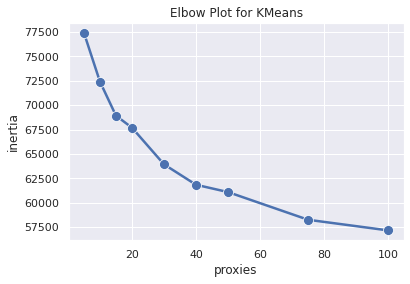

+-----------+-----------+
|   proxies |   inertia |
|-----------+-----------|
|         5 |   77426.6 |
|        10 |   72409.6 |
|        15 |   68920.7 |
|        20 |   67685.9 |
|        30 |   63923   |
|        40 |   61829.6 |
|        50 |   61077.8 |
|        75 |   58237.5 |
|       100 |   57146.6 |
+-----------+-----------+


In [ ]:
import seaborn as sns, pandas as pd, matplotlib.pyplot as plt, tabulate
sns.set_theme(style="darkgrid")
datadf=pd.DataFrame(list(zip(cluster_range,inertia)), columns=["proxies", "inertia"])
#datadf["inertia"] = datadf["inertia"] / max(datadf["inertia"])
fig, ax1 = plt.subplots() # initializes figure and plots
#ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
sns.lineplot(x="proxies", y="inertia", data=datadf, 
             palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax1)
plt.title("Elbow Plot for KMeans")
#plt.ylim(0,1.05)
#sns.lineplot(x="proxies", y="silhouette", data=datadf, 
#             palette="tab10", linewidth=2.5, marker="o", markersize=10, ax=ax2)
plt.show()
print(tabulate.tabulate(datadf, headers="keys", showindex=False, tablefmt="psql"))

## Generating Plugins for a trained model

We will need to generate the following plugins:
- l2-kmp
- cos-kmp
- high-density set
- randomized lipschitz
- logit confidence

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
ed = EdnaDeploy(config = ["./GLAMOR/profiles/PolitiFact/gossipcop.yml",
                          "./GLAMOR/profiles/FNC/experts/configs/plugin_base.yml"], dataloader_mode = "train")

ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["shard_replace"] = False
ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["data_shuffle"] = False

# PROXIES
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = 40
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["proxies"] = 40
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["proxies"] = 40

ed.add("./GLAMOR/profiles/PolitiFact/politifact-crawler.py")


05:30:26 Adding a crawler, from /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py, with inferred name PolitifactCrawler


Log file exists at fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1-albert-base-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/PolitiFact/politifact-crawler.py.PolitifactCrawler'>, from file: /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py


In [ ]:
ed.apply(skip_model_summary=True)

05:30:26 ****************************************
05:30:26 
05:30:26 
05:30:26 Using the following configuration:
05:30:26 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      fake_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv
      split: 0.9
      true_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv
    DATALOADER_ARGS: {}
    DATAREADER: HFReader
    DATASET_ARGS:
      annotation_idxs: []
      classificationclass:
      - fnews
      data_shuffle: false
      keyword_mask: true
      keywords: []
      label_idxs:
      - 1
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-gossipcop-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS:
      from_pretrained: albert-base-v2
      tokenizer: HFAutoTokenizer
  DEPLOY: HFDeploy
  DEPLOYMEN

5641841/12538704 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_fake.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv completed
8966615/19978126 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_real.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv completed


05:30:27 Generating dataloader `HFGenerator` with `train` mode


Building Transforms
Building Dataset


05:30:29 Generated test data/query generator
05:30:29 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
#ed.previous_stop = 6
ed.deploy()

05:30:33 Starting deployment
05:30:33 Logging to:	fnc-gossipcop-v1-albert-base-logger.log
05:30:33 Loading a model from saved epoch 2
05:30:33 Loading model from local backup.
05:30:33 Finished loading model state_dict from fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1_epoch2.pth
05:30:33 Looking for model plugins from local backup.
05:30:33 No plugins found at fnc-gossipcop-v1-albert-base/fnc-gossipcop-v1_plugins.pth
05:30:33 Setting up plugin hooks. Plugins will fire during:  warmup
05:30:33 Executing deployment for  2 epochs
05:30:33 Starting epoch 0


Starting KMeans for k=40, with 30 iterations
	[0.74 s] -- Completed 0 iterations
	[2.83 s] -- Completed 5 iterations
	[2.83 s] -- Completed 10 iterations
	[2.86 s] -- Completed 15 iterations
	[2.96 s] -- Completed 20 iterations
	[2.86 s] -- Completed 25 iterations
	Competed MBKM for k=40, with inertia: 63024.94140625
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=40, with 30 iterations
	[0.66 s] -- Completed 0 iterations
	[2.85 s] -- Completed 5 iterations
	[2.84 s] -- Completed 10 iterations
	[2.83 s] -- Completed 15 iterations
	[2.84 s] -- Completed 20 iterations
	[2.82 s] -- Completed 25 iterations
	Competed MBKM for k=40, with inertia: 63024.94140625
Starting High Density estimation
Completed High Density threshold estimation
Starting KMeans for k=40, with 30 iterations
	[0.67 s] -- Completed 0 iterations
	[2.84 s] -- Completed 5 iterations
	[2.86 s] -- Completed 10 iterations
	[2.86 s] -- Completed 15 iterations
	[2.86 s] -- Comp

05:32:22 RandomizedLipschitz starting Lipschitz stage
05:32:22 Executing end of epoch steps
05:32:22 Starting epoch 1


Completed High Density threshold estimation


05:32:56 RandomizedLipschitz has completed Lipschitz stage. Computing L values.
05:32:56 Performing save at epoch 2
05:32:56 Saving model plugins.
05:32:56 Saved plugins: dict_keys(['FastKMP-l2', 'FastKMP-cos', 'FRL-midas', 'logit-confidence'])
05:32:56 Executing end of epoch steps
05:32:56 Completed deployment task.


In [ ]:
ed.model.plugins["FRL-midas"].proxy_label

tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

## Use Plugins (test)

In [ ]:
#!rm -rf -- train-datashard-artifacts/
#!rm -rf -- test-datashard-artifacts/

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import h5py, os
class PluginsTestDeploy(HFDeploy):
  def deploy_step(self, batch):
    batch = tuple(item.cuda() for item in batch)
    (
        all_input_ids,
        all_attention_mask,
        all_token_type_ids,
        all_masklm,
        all_annotations,
        all_labels
    ) = batch
    outputs = self.model(
        all_input_ids,
        token_type_ids=all_token_type_ids,
        attention_mask=all_attention_mask,
        output_attentions = True,
        output_hidden_states = True,
        secondary_inputs=all_annotations       # NOT for HFTrainer! because it only expects specific inputs!
    )

    logits = outputs[0]
    secondaries = outputs[2]
    
    return logits, all_labels, secondaries
  def output_setup(self, **kwargs):
    self.ofile = kwargs.get("output_filename")
    self.oobj = open(self.ofile, "w")
    self.oobj.write(",".join([
      "gt_label",
      "predicted_label",
      "l2_dist",
      "l2_hdthreshold",
      "l2_proxylabels",
      "cos_dist",
      "cos_hdthreshold",
      "cos_proxylabels",
      "l_score",
      "smooth_l_score",
      "l_threshold",
      "smooth_l_threshold",
      "l_proxylabel",
      "logit_raw",
      "logit_threshold"
      ])+"\n")
  def output_step(self, logits, all_labels, secondary):
    # outputs is a list, where the post is in outputs[2], I think????
    # In any case, we need to check ouputs[2] to get the threshold...
    predicted_label = torch.argmax(torch.nn.functional.softmax(logits.cpu(), dim=1), dim=1).tolist()
    l2_dist = secondary[2]["FastKMP-l2"]["distance"].to(torch.float32).tolist()
    l2_hdthreshold = secondary[2]["FastKMP-l2"]["threshold"].to(torch.float32).tolist()
    l2_proxylabels = secondary[2]["FastKMP-l2"]["proxy_labels"].to(torch.float32).tolist()
    
    cos_dist = secondary[2]["FastKMP-cos"]["distance"].to(torch.float32).tolist()
    cos_hdthreshold = secondary[2]["FastKMP-cos"]["threshold"].to(torch.float32).tolist()
    cos_proxylabels = secondary[2]["FastKMP-cos"]["proxy_labels"].to(torch.float32).tolist()

    l_score = secondary[2]["FRL-midas"]["l_score"]
    smooth_l_score = secondary[2]["FRL-midas"]["smooth_l_score"]
    l_threshold = secondary[2]["FRL-midas"]["l_threshold"]
    smooth_l_threshold = secondary[2]["FRL-midas"]["smooth_l_threshold"]
    l_proxylabel = secondary[2]["FRL-midas"]["proxy_label"].to(torch.float32).tolist()

    logit_raw = secondary[2]["logit-confidence"]["logit"].to(torch.float32).tolist()
    logit_threshold = secondary[2]["logit-confidence"]["logit_threshold"].to(torch.float32).tolist()
    gt_label = all_labels[:,0].tolist()

    output_list = [",".join(map(str,item)) for item in zip(
      gt_label,
      predicted_label,
      l2_dist,
      l2_hdthreshold,
      l2_proxylabels,
      cos_dist,
      cos_hdthreshold,
      cos_proxylabels,
      l_score,
      smooth_l_score,
      l_threshold,
      smooth_l_threshold,
      l_proxylabel,
      logit_raw,
      logit_threshold
      )]
    self.oobj.write("\n".join(output_list)+"\n")

  def end_of_epoch(self, epoch: int):
      self.oobj.close()

In [ ]:
ed = EdnaDeploy(config = ["./GLAMOR/profiles/PolitiFact/config.yml",
                          "./GLAMOR/profiles/FNC/experts/configs/plugin_base.yml"], 
                config_inject = [
                 ("SAVE.SAVE_FREQUENCY", 5),
                 ("DEPLOYMENT.EPOCHS", 1),
                 ("DEPLOYMENT.PLUGIN.HOOKS", "activated"),
             ])#,
             #dataloader_mode = "train")

ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["shard_replace"] = False
ed.cfg.DEPLOYMENT.DATAREADER.DATASET_ARGS["data_shuffle"] = False

#ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["true_url"] = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv"
#ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["fake_url"] = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv"

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["output_filename"] = ed.saveMetadata.MODEL_SAVE_FOLDER+".csv"


# PROXIES
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = 40
ed.cfg.MODEL_PLUGIN["FastKMP-cos"].PLUGIN_KWARGS["proxies"] = 40
ed.cfg.MODEL_PLUGIN["FRL-midas"].PLUGIN_KWARGS["proxies"] = 40

ed.add("./GLAMOR/profiles/PolitiFact/politifact-crawler.py")
ed.addDeploymentClass(PluginsTestDeploy)

05:52:18 Adding a crawler, from /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py, with inferred name PolitifactCrawler


Injected key-value pair:  SAVE.SAVE_FREQUENCY, 5
Injected key-value pair:  DEPLOYMENT.EPOCHS, 1
Injected key-value pair:  DEPLOYMENT.PLUGIN.HOOKS, activated
Log file exists at fnc-politifact-v1-albert-base/fnc-politifact-v1-albert-base-logger.log. Will attempt to append there.
Registering a crawler: <class './GLAMOR/profiles/PolitiFact/politifact-crawler.py.PolitifactCrawler'>, from file: /content/GLAMOR/profiles/PolitiFact/politifact-crawler.py


In [ ]:
ed.apply(skip_model_summary=True)

05:52:18 ****************************************
05:52:18 
05:52:18 
05:52:18 Using the following configuration:
05:52:18 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      fake_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv
      split: 0.9
      true_url: https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv
    DATALOADER_ARGS: {}
    DATAREADER: HFReader
    DATASET_ARGS:
      annotation_idxs: []
      classificationclass:
      - fnews
      data_shuffle: false
      keyword_mask: true
      keywords: []
      label_idxs:
      - 1
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-politifact-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS:
      from_pretrained: albert-base-v2
      tokenizer: HFAutoTokenizer
  DEPLOY: HFDeploy
  DEPLOYME

5641841/12538704 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_fake.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv completed
8966615/19978126 bytes [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of politifact_real.csv to https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv completed


05:52:19 Generating dataloader `HFGenerator` with `test` mode


Building Transforms


05:52:21 Generating shards


Building Dataset


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
05:52:24 Generated test data/query generator
05:52:24 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

NOT saving metadata. saveMetadata() function not set up.


In [ ]:
#ed.previous_stop = 6
ed.deploy()

05:52:27 Starting deployment
05:52:27 Logging to:	fnc-politifact-v1-albert-base-logger.log
05:52:27 Loading a model from saved epoch 10
05:52:27 Loading model from local backup.
05:52:27 Finished loading model state_dict from fnc-politifact-v1-albert-base/fnc-politifact-v1_epoch10.pth
05:52:28 Looking for model plugins from local backup.
05:52:28 Loading plugin with name FastKMP-l2
05:52:28 Loading plugin with name FastKMP-cos
05:52:28 Loading plugin with name FRL-midas
05:52:28 Loading plugin with name logit-confidence
05:52:28 Loaded plugins from fnc-politifact-v1-albert-base/fnc-politifact-v1_plugins.pth
05:52:28 Setting up plugin hooks. Plugins will fire during:  activated
05:52:28 Executing deployment for  1 epochs
05:52:28 Starting epoch 0
05:52:37 Executing end of epoch steps
05:52:37 Completed deployment task.


In [ ]:
import pandas as pd, numpy as np
def remove_dup_columns(frame):
     keep_names = set()
     keep_icols = list()
     for icol, name in enumerate(frame.columns):
          if name not in keep_names:
               keep_names.add(name)
               keep_icols.append(icol)
     return frame.iloc[:, keep_icols]
df = pd.read_csv(ed.saveMetadata.MODEL_SAVE_FOLDER+".csv")

In [ ]:
dfl2 = df[(df["l2_dist"] < df["l2_hdthreshold"])]
dfl2ex = df[(df["l2_dist"] < df["l2_hdthreshold"]) & (df["predicted_label"] == df["l2_proxylabels"])]
dfcos = df[(df["cos_dist"] < df["cos_hdthreshold"])]
dfcosex = df[(df["cos_dist"] < df["cos_hdthreshold"]) & (df["predicted_label"] == df["cos_proxylabels"])]
dflogit = df[(df["logit_raw"] > df["logit_threshold"])]
dfl = df[(df["l_score"] < df["l_threshold"])]
dflex = df[(df["l_score"] < df["l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]
dfsmoothl = df[(df["smooth_l_score"] < df["smooth_l_threshold"])]
dfsmoothlex = df[(df["smooth_l_score"] < df["smooth_l_threshold"]) & (df["predicted_label"] == df["l_proxylabel"])]
dfl2join = dfl2.join(dfl2ex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfcosjoin = dfcos.join(dfcosex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfljoin = dfl.join(dflex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfsmoothljoin = dfl.join(dfsmoothlex, how="inner", lsuffix="left")[["gt_label", "predicted_label"]]
dfall = pd.concat([dfl2,dfl2ex,dfcos,dfcosex,dflogit,dfl,dflex,dfsmoothl,dfsmoothlex], axis=1, join='inner')[["gt_label", "predicted_label"]]
dfall = remove_dup_columns(dfall)

In [ ]:
from sklearn.metrics import classification_report
reportfile = ed.saveMetadata.MODEL_SAVE_FOLDER+"report.txt"
robj = open(reportfile, "w")
outputs = {"Baseline": df, 
            "KMP-L2": dfl2, "KMP-L2-HighDensity":dfl2ex,
           "KMP-Cos": dfcos, "KMP-Cos-HighDensity":dfcosex,
           "LogitConfidence": dflogit,
           "L-Score": dfl, "LScore-HighDensity":dflex,
           "Smooth-L-Score": dfsmoothl, "Smooth-L-Score-HighDensity":dfsmoothlex,
           "KMP-L2-joined": dfl2join, "KMP-Cos-joined":dfcosjoin,
           "L-Score-joined": dfljoin, "Smooth-L-Score-joined":dfsmoothljoin,
           "AllConditions": dfall}
import warnings
warnings.filterwarnings('ignore')
for item in outputs:
  print("-------------------- {label} -----------------".format(label=item))
  robj.write("-------------------- {label} -----------------\n".format(label=item))
  if len(outputs[item]["gt_label"]) and len(outputs[item]["gt_label"].unique()) == 2:
    resp=classification_report(outputs[item]["gt_label"], outputs[item]["predicted_label"])
    print(resp)
    robj.write(resp+"\n")
robj.close()

-------------------- Baseline -----------------
              precision    recall  f1-score   support

           0       0.26      0.82      0.39       533
           1       0.81      0.25      0.38      1682

    accuracy                           0.38      2215
   macro avg       0.54      0.53      0.38      2215
weighted avg       0.68      0.38      0.38      2215

-------------------- KMP-L2 -----------------
              precision    recall  f1-score   support

           0       0.31      0.87      0.45        67
           1       0.74      0.16      0.26       155

    accuracy                           0.37       222
   macro avg       0.52      0.51      0.36       222
weighted avg       0.61      0.37      0.32       222

-------------------- KMP-L2-HighDensity -----------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                  

In [ ]:
len(ed.crawler.metadata["train"]["crawl"])

19925